<a href="https://colab.research.google.com/github/Areeb297/Potential-Talents-Human-Resources-Staffing---Apziva-Project/blob/main/Potential_Talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Project Summary**

A talent sourcing and management company requires automating the process of identifying and ranking the best candidates for various roles where the current manual process is challenging and labor-intensive. The key challenges the company faces are:

1. Understanding the role: Accurately interpreting client's needs and expectations for potential candidates

2. Evaluating Candidates: Determining what makes a candidate suitable for a given role.

3. Sourcing talent: Finding qualified individuals from a large pool of candidates.

To address, the aim of this project is to develop a ML-powered pipeline that automates candidate ranking based on their "fitness" for a specific role. Additionally, this system should adaptively re-rank candidates based on the human reviewer initial seletion such that the model re-ranks the list to better align with the reviewer's preferences, considering the starred candidate as the most important for this particular role. This will imporove the rankings generated by system over time.

#### **Key Requirements:**

* Fitness prediction
* Ranking
* Re-ranking
* Mitigate Human Bias in the process
* Filtering

### **Data Description:**

The dataset contains anonymized candidate information sourced through the company's semi-automated process and sourcing efforts.

Attributes:

1. id: Unique numeric identifier for each candidate
2. job_title: Text description of the candidate's job title.
3. location: Geographical location of the candidate.
4. connections: Number of professional connections the candidate has (e.g., 500+ indicates more than 500 connections).
5. fit: Target variable indicating the candidate's fitness score (numeric probability between 0 and 1). We can use cosine-similarity for this.

Currently, the fit column is empty so we need to employ NLP techniques such as TF-IDF, Word2Vec, Bert, Open source LLMs etc to match our search with job_title, location, and connections (the more the connections, the better it is as it is considered an added benefit).

### **Keywords:**
The data is based on searching specifc keywords for roles:
1. Aspiring human resources
2. Seeking human resources

### **Goals & Objective:**
1. Build a predictive model to calculate fitness score for each candidate based on given query.
2. Use fitness scores to rank candidates for specific roles.
3. Enable re-ranking based on manual feedback (starring action).
4. Identify methods to filter out candidates which in the first place should not be in this list?
5. Define an adaptive cut-off point that would work for other roles to exclude low-potential candidates while retaining high-potential ones.


The objective is to develop an intelligent candidate ranking system to ensure best and most talented candidates are selected to technology companies using NLP techniques such as TF-IDF, Cosine Similarity, Word2Vec, Transformer-Based Models and leveraging open source LLMs with frameworks like LangChain to automate aspects of candidate evaluation process.


### Import Relevant Libaries

In [ ]:
!pip install nltk

In [ ]:
from google.colab import drive
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

**Picking a Random Seed**

In [ ]:
# Mount google drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/Apziva AI Residency/Project 3"
os.chdir(project_path)

print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Apziva AI Residency/Project 3


In [ ]:
# Pick a random seed

# np.random.randint(0, 20000)

In [ ]:
# Pick a random seed
random_seed = 16166 # We use this random seed as after 100 iterations of using LazyClassifier, this gives best results.
print(f"Using random seed: {random_seed}")

# Set the random seed across different libraries
random.seed(random_seed)
np.random.seed(random_seed)

Using random seed: 16166


#### Loading & Cleaning Data

In [ ]:
import pandas as pd

df = pd.read_csv('potential-talents.csv')

In [ ]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [ ]:
df.describe(include='object')

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


It looks as though the spelling of Kanada is incorrect, let us change that.
Additionally, there seems to be null data in the three columns, job_title, location, and connection.

Lastly, id column seems redundant, as the index column is present already, will remove that as well.

In [ ]:
# Correct the spelling of Canada
df['location'] = df['location'].replace('Kanada', 'Canada')


# Remove the id column as not required
df.drop('id', axis=1, inplace=True)

We need a way to sort the data based on connections but connection is in object
format. Let us convert it to numerical and the value for 500+ can be used.

We will map the 500+ to 501 numerically and create a new column called
connection_numeric.

In [ ]:
df.head()

,job_title,location,connection,fit
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [ ]:
# Function to convert connections to numerical values
def convert_connections(value):
    if value == '500+ ':
        return 501  # Use a number slightly higher than 500 for sorting
    else:
        return int(value)

# Apply the function to the connections column
df['connections_numeric'] = df['connection'].apply(convert_connections)

In [ ]:
df.sort_values('connections_numeric', ascending=False).head(10)

,job_title,location,connection,fit,connections_numeric
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
7,HR Senior Specialist,San Francisco Bay Area,500+,NaN,501
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501
12,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,NaN,501
15,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501
11,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN,501
9,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN,501
33,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501
34,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501


## Exploratory Data Analysis

Let us visualize what the distribution of number of connections looks like in our talent pool sourced for HR positions


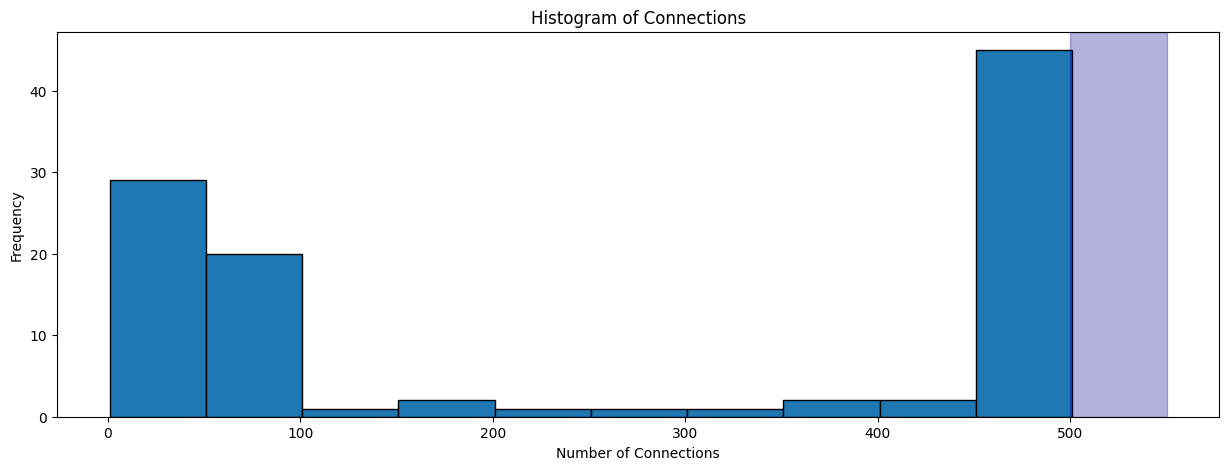

In [ ]:
# Plotting the histogram
plt.figure(figsize=(15, 5))  # Optional: Adjust the figure size for better visibility
plt.hist(df['connections_numeric'], bins=10, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Connections')
plt.xlabel('Number of Connections')
plt.ylabel('Frequency')

plt.axvspan(500, 550, color='darkblue', alpha=0.3, label='Connections > 500')

# Display the plot
plt.show()


We see that majority of the candidates have connections more than 500+ connections on LinkedIn and the second highest category is the group with connections less than 100 (in opposite ends).

In [ ]:
# Let us see which locations seem to be the most popular in our results.
df.connection.value_counts().head(15)

,count
connection,
500+,44
85,7
61,7
44,6
1,5
2,4
390,2
57,2
7,2


In [ ]:
# Let us see which locations seem to be the most popular in our results.
df.location.value_counts().head(15)

,count
location,
Canada,12
"Raleigh-Durham, North Carolina Area",8
"Houston, Texas Area",8
Greater New York City Area,7
"Houston, Texas",7
"Denton, Texas",6
Greater Philadelphia Area,5
San Francisco Bay Area,5
"İzmir, Türkiye",4


It seems majority of the search results are employees from Canada,
North Carolina, Houston, New York etc. But we do see that there
are some potential duplicates like Texas Area and Texas.

After further research, there is a difference between the two as
Houston, Texas for example refers specifically to the city of Houston
whereas Houston, Texas Area encompasses not only the city of Houston
but also the surrounding metropolitan area. So we can leave it as it is.

#### Visualize the data (job titles) in a word cloud.

For that, firstly let us remove Stop Words using nltk library

In [ ]:
# Download the stopwords dataset
nltk.download('stopwords')

nltk.download('punkt')  # Necessary for word_tokenize
# It is a pre-trained tokenizer model in NLTK
# word_tokenize uses punkt model to intelligently handle punctuations, contractions,
# and special cases.

# Without punkt, the information to handle punctuation, contractions, and special
# cases will not be there for word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
import string
nltk.download('punkt')  # Downloads the punkt tokenizer resource
nltk.download('stopwords')  # Downloads the stopwords list
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Using string libary, stopwords, punkt etc., we remove stopwords such as the, and, and additionally common punctuation marks like brackets, quotation marks, full stops etc.

In [ ]:
# Function to remove stop words from text and convert text to lowercase
# for consistency

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
    return ' '.join(filtered_words)


# Apply the function to remove stop words but keep the original job_title column
df['job_title_cleaned'] = df['job_title'].apply(remove_stop_words).str.lower()

In [ ]:

df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t bauer college business graduate magna...
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik english program korea
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university


In the above, we can now also use connections_numeric to sort the most talented candidates.

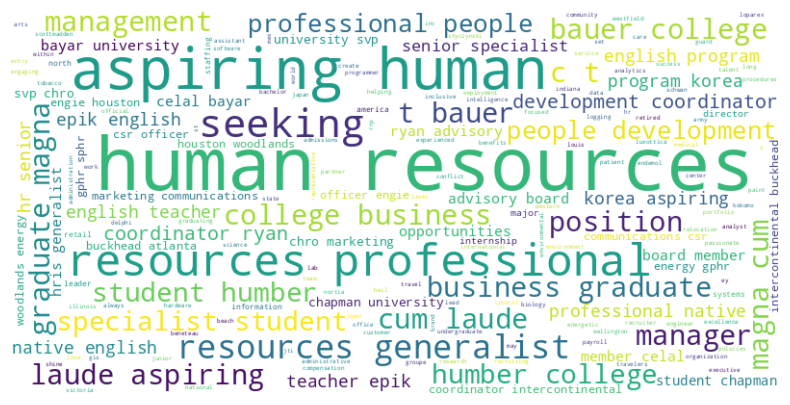

In [ ]:
# Visualize the new column as a word cloud
# Combine all job titles into a single string
text = ' '.join(df['job_title_cleaned'])
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axes
plt.show()

It looks as the Word Cloud visualization highlights key terms such as "aspiring", "manager", "human resources" etc., are the most frequently occuring words. This aligns with what the initial keywords were ("Aspiring human resources" & "seeking human resources"). However, some words like "magna", "laude", "epik" appear which are associated with university honours or institution names.

While these reflect academic achievements or affiliations, they may not be directly relevant to identifying the most talented candidates purely based on their professional capabilities. University reputation or a business degree from college could play an important role in candidate evaluation however not all rows or job titles given contain that information. Thus, filtering based on these solely might overlook other strong contenders who have identified themselves as "aspiring HR professionals". But based on what the user searches, these terms will be helpful in distinguishing the requested candidates using cosine similarity etc.

### TF-IDF (Term Frequency-Inverse Document Frequency)

This is a statistical technique used to evaluate the importance of a word in a document relative to a collection of documents (or a corpus).

TF = # Times the term appears in document / # Terms in the document

IDF = Log (Total Documents / Number of Documents containing the term)

Tf-IDF = Tf x IDF

This helps to assign a weight to each term and highlight words that are meaningful and relevant for a given document. This can help to identify the most significant words in candidates' job titles or descriptions.

The above will calculate TF-IDF score for each word based on:
1. How frequent the word is in the specific sentence or document
2. How rare the word is across the entire dataset.

The first step would be to tokenize the text however with TF-IDF libraries such as TfidfVectorizer from sklearn, this is automatically handled for us.

For each job title, we will calculate the TF-IDF vector and then afterward, represent each job title as its corresponding vector in the matrix. We will store that as a new column in our dataframe e.g., df['job_title_vectorized]'

We also require location enabled search so we will combine job_title & location into a single column, compute TF-IDF, and then use that for similarity calculation.

In [ ]:
# Clean the location column

df['location_cleaned'] = df['location'].str.lower().str.replace('[^\w\s]', '', regex=True)

# Combine job_title and location into a single column

df['combined_text'] = df['job_title'] + " " + df['location_cleaned']


# Initialize a new TfidfVectorizer for combined text
tfidf_vectorizer_combined = TfidfVectorizer()
tfidf_matrix_combined = tfidf_vectorizer_combined.fit_transform(df['combined_text'])

# Convert the TF-IDF matrices to lists for DataFrame storage
tfidf_values_job_title_location = tfidf_matrix_combined.toarray().tolist()


# Add new columns to store TF-IDF values
df['tfidf_values_combined'] = tfidf_values_job_title_location

# Display the DataFrame with the new columns
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t bauer college business graduate magna...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik english program korea,canada,Native English Teacher at EPIK (English Progra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university,izmir türkiye,Advisory Board Member at Celal Bayar Universit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### Cosine Similarity

Cosine Similarity is a metric used to measure similarity between two vectors by calculating the cosine of the angle between them in high-dimensional space.

Cosine Similarity Values Range from:
* +1 - Perfectly Similar
* 0 - No similarity
* -1 - Perfectly dissimilar.

Formula:

Cosine Similarity = A . B / ||A|| ||B||

It is used for text & document similarity as it measures the degree of similarity between text vectors helping in ranking, clustering, and matching text data. It is also computationally efficient & works well with sparse data.



Now that we have vectorized our job_title_location combined column, let us convert our query to a vector, then use cosine similarity and use the connections_numeric column to get the most relevant results. We will populate the 'fit' column with our cosine similarity values.

In [ ]:

# Define functions that can tokenize & vectorize the query,
# perform cosine similarity, and output the relevant results.


# Additionally, at the end, will also sort the results by number of connections
# in descending order as we would prefer someone well connected and talented.

# Preprocess the query (e.g., lowercase, remove stop words)
def preprocess_query(query):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word.lower() for word in word_tokenize(query) if word.lower() not in stop_words])


# Function to process query, compute cosine similarity, and return top results
def get_top_matches(query, tfidf_vectorizer, tfidf_matrix_combined, df, top_n=10):
    # Preprocess the query
    query_cleaned = preprocess_query(query)

    # Transform the query into vectors for both job_title and location
    query_vector_combined = tfidf_vectorizer.transform([query_cleaned])


    # Compute cosine similarity between the query vector and all job titles
    similarity_scores = cosine_similarity(query_vector_combined, tfidf_matrix_combined).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                    job_title  \
7                        HR Senior Specialist   
25                       HR Senior Specialist   
37                       HR Senior Specialist   
50                       HR Senior Specialist   
60                       HR Senior Specialist   
82  HR Manager at Endemol Shine North America   
2       Aspiring Human Resources Professional   
16      Aspiring Human Resources Professional   
20      Aspiring Human Resources Professional   
32      Aspiring Human Resources Professional   

                               location connection       fit  
7                San Francisco Bay Area      500+   0.353966  
25               San Francisco Bay Area      500+   0.353966  
37               San Francisco Bay Area      500+   0.353966  
50               San Francisco Bay Area      500+   0.353966  
60               San Francisco Bay Area      500+   0.353966  
82    

**Observations:** The above works correctly when the query is very specific however, it cannot recognize HR being Human Resources so when I query Aspiring HR, it returns HR Specialist as a top result but when I write the whole words, the result works as expected. Context cannot be recognized from generated word embeddings by Tf-IDF, with transformer based approaches, this problem is solved



1.   The above is a common limitation of the TF-IDF approach in its ability to recognize that abbreviations like HR correspond to Human Resources. This occurs due to the fact that TF-IDF treats each term as distinct and lacks the semantic understanding to link abbreviations to their full forms.
2.   Term Independence results in TF-IDF not understanding relationships between terms & their contextual usage.

To solve this, we can use Word Embeddings models such as Word2Vec, GloVe to generate dense vector representation of words, capturing semantic relationships.

Additionally, transformer-based models like BERT can understand context better and capture meanings of phrases and abbreviations within their usage.


#### Re-rank candidates when a candidate is starred

After the user "stars" or selects a candidate, they signal that this candidate is an **ideal match** therefore, the system can use this supervisory signal to adjust the ranking, prioritizing candidates that are similar to the starred candidate. This re-ranking process ensures that future results will reflect the qualities of the starred candidate.

To implement this re-ranking mechanism, we perform initial search as usual, once a user stars a candidate, we can treat this candidate's TF-IDF or semantic embedding as a new benchmark. Using this vector, we compute cosine similarity between the starred candidate's vector and all other candidate's vectors.

Then, we re-rank the list based on the new similarity scores and display the updated list to the user.

Below is the updated implementation of searhing relevant candidates now incorporating re-ranking functionality.

In [ ]:
def rerank_candidates(starred_vector, tfidf_matrix, df):
    """Re-rank candidates based on similarity to the starred candidate."""
    # Compute cosine similarity between starred vector and all others
    similarities = cosine_similarity(starred_vector, tfidf_matrix).flatten()

    # Add similarity scores to the DataFrame
    df['fit'] = similarities

    # Sort by similarity score in descending order
    df_sorted = df.sort_values(by='fit', ascending=False)

    # Return the re-ranked DataFrame
    return df_sorted[['job_title', 'location', 'fit']]


while True:
    # Get user input
    query = input("Enter your search query (or type 'exit' to quit): ").strip()
    if query.lower() == 'exit':
        print("Exiting the search.")
        break

    # Call the function to get top matches
    top_results = get_top_matches(query, tfidf_vectorizer_combined, tfidf_matrix_combined, df)

    # Display the top results
    print("\nTop Matches:")
    print(top_results)

    while True:
        try:
            # Ask user to star a candidate from the displayed results
            star_input = input("\nEnter the index of the candidate you want to star (or type 'back' to perform another search): ").strip()
            if star_input.lower() == 'back':
                print("Returning to search...")
                break

            # Convert the input to an integer (index in the DataFrame)
            star_index = int(star_input)

            if star_index < 0 or star_index >= len(top_results):
                print(f"Invalid index. Please select an index between 0 and {len(top_results) - 1}.")
                continue

            # Get the vector of the starred candidate
            starred_vector = tfidf_matrix_combined[top_results.index[star_index]]

            # Re-rank the candidates based on similarity to the starred candidate
            re_ranked_results = rerank_candidates(starred_vector, tfidf_matrix_combined, df)

            # Display the re-ranked results
            print("\nRe-Ranked Results Based on Your Starred Candidate:")
            print(re_ranked_results.head(10))  # Show top 10 results after re-ranking
        except ValueError:
            print("Invalid input. Please enter a valid index or 'back' to perform another search.")

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                    job_title  \
7                        HR Senior Specialist   
25                       HR Senior Specialist   
37                       HR Senior Specialist   
50                       HR Senior Specialist   
60                       HR Senior Specialist   
82  HR Manager at Endemol Shine North America   
2       Aspiring Human Resources Professional   
16      Aspiring Human Resources Professional   
20      Aspiring Human Resources Professional   
32      Aspiring Human Resources Professional   

                               location connection       fit  
7                San Francisco Bay Area      500+   0.353966  
25               San Francisco Bay Area      500+   0.353966  
37               San Francisco Bay Area      500+   0.353966  
50               San Francisco Bay Area      500+   0.353966  
60               San Francisco Bay Area      500+   0.353966  
82    

The above works as expected where once I selected the 3rd candidate where the location was North Carolina, in my updated re-ranked list, all top candidates with the same job title keywords and location show up as the top results, thus having 100% fit as shown.

Now the next step will be to experiment with other vector embedding techniques such as Word2Vec, BERT, and additionally open-source LLMs.

### Word2Vec

Word2Vec is a neural network based approach in NLP where it transforms words into continuous vector representations, and is able to capture meanings based on given context unlike TF-IDF. It was developed by a team at Google in 2013, we can use it to better understand semantic relationships between words.

Word2Vec employs 2 main methods: Continuous Bag of Words (CBOW) and Skip-Gram. Both models are trained on large text corpora in high-dimensional vector space.

When it comees to **CBOW, it predicts a word based on the words around it. This is fast**, and works well for common words. The context is defined a pre-defined window size which determines how many words before and after the target word are considered. The average vector that is calculated is passed through a small neural network where the word with the highest probability is predicted as the target word. CBOW does not care about the word order, it learns word relationships by adjusting the word vectors during training so that the average vector matches the target word.

Concerning <u>**Skip-Gram, the idea is to predict context words from the target, it essentially works the other way around.** For each target word, the model uses it to predict the context words within the same window size, this method is **slow but more precise**</u> as it is useful for learning high quality word vectors for rare words. **Skip-Gram uses negative sampling** which updates only a small number of weights instead of all vocabulary words, it picks a few negative words and ensures the model assigns low probabilities to them.

<u>Key Differences between CBOW & Skip-Gram</u>

Prediction Direction:

*   CBOW predicts the target word from context words
*   Skip-Gram predicts context words from the target word.

Training Speed:


*   CBOW trains faster due to its averaging approach of taking the average of the vectors of context words within a pre-defined window size around the target words.
*   Skip-Gram trains slower but captures more detailed word relationships, it works by assigning higher weights to nearby context words, capturing the order and distance of words in the context.



Performance with Rare Words:



*   CBOW may not perform as well with infrequent words
*   Excels at learning representations for rare words as the model learns representation of words by analyzing contexts in which they occur. By focusing on predicting context words, Skip-Gram captures the relationships between a rare word and its neighboring words.




<u>***Comparison between TF-IDF & Word2Vec:***</u>

TF-IDF is a statistical measure that evaluates the importance of word in a document relative to collection of documents focusing on term frequency & inverse document frequency. Thus, it cannot capture the semantic understanding between words, as it treats each word independently.

Word2Vec on the other hand, captures semantic and syntactic relationships by learning from word contexts in the corpus, producing dense, continuous vector representations where similar words have similar vectors enabling the model to understand relationships such as king -> man etc.





1.   First thing would be to use gensim library to train a Word2Vec Model (Skip Gram) on tokenized text.
2.   We use the same process as we did for TF-IDF, where we use cosine similarity to retrieve top matches.



In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)

# Step 3: Training a Word2Vec Model (CBOW)
# sentences=df['tokenized_text']: The input text in tokenized form.
# vector_size=1000: Sets the dimensionality of the word vectors to 1000.
# window=10: Defines the maximum distance between the current and predicted words within a sentence.
# min_count=5: Ignores words that appear fewer than 5 times in the corpus.
# sg=1: Specifies the Skip-Gram architecture (sg=0 would use CBOW).
# Parameters: sg=1 for Skip Gram, vector_size=1000 for 1000-dimensional embeddings, window=5 for context window size
# This will create word embeddings from scratch based on the existing dataset only

word2vec_model = Word2Vec(sentences=df['tokenized_text'], vector_size=1000,
                          window=10, min_count=5, sg=1)

# Step 4: Vectorize Each Combined Text
def vectorize_text(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Average the vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the vocabulary

df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, word2vec_model))

# Step 5: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 6: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
df.head()

,job_title,location,connection,fit,connections_numeric,job_title_cleaned,location_cleaned,combined_text,tfidf_values_combined,tokenized_text,word_2_vec_vectorized_text
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,85,2019 c.t bauer college business graduate magna...,houston texas,2019 C.T. Bauer College of Business Graduate (...,"[0.3006376441281749, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2019, C.T, ., Bauer, College, of, Business, G...","[0.00062621257, -0.00012966397, 0.0002862305, ..."
1,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN,501,native english teacher epik english program korea,canada,Native English Teacher at EPIK (English Progra...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Native, English, Teacher, at, EPIK, (, Englis...","[0.001009853, -0.00011815492, 0.00015507784, 0..."
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,44,aspiring human resources professional,raleighdurham north carolina area,Aspiring Human Resources Professional raleighd...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Aspiring, Human, Resources, Professional, ral...","[0.00029400678, -0.00022105308, 0.00034174672,..."
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,501,people development coordinator ryan,denton texas,People Development Coordinator at Ryan denton ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[People, Development, Coordinator, at, Ryan, d...","[-7.708349e-06, 0.00034330317, 0.00017242972, ..."
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,501,advisory board member celal bayar university,izmir türkiye,Advisory Board Member at Celal Bayar Universit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Advisory, Board, Member, at, Celal, Bayar, Un...","[-1.4852398e-05, 0.000132029, 4.0581624e-05, 0..."


In [ ]:
# Provides an interactive way to search for matches by continuously
# accepting user queries and displaying the top results.

while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, word2vec_model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title            location  \
65  Experienced Retail Manager and aspiring Human ...  Austin, Texas Area   
0   2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
14  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
18  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
30  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
43  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
56  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
6   Student at Humber College and Aspiring Human R...              Canada   
8   Student at Humber College and Aspiring Human R...              Canada   

   connection       fit  
65         57  0.564380  
0          85  0.523912 

It seems the performance is quite poor when using Word2Vec for SkipGram, additionally, even if we experiment with CBOW, the performance is still nearly the same. This is becasue our dataset is relatively small, we require using a pre-trained Word2Vec model to get better performance. A few hundred rows to train a Word2Vec model results in poor accuracy Word2Vec requires a large corpus of data to generate meaningful embeddings as there is limited vocabulary and many words not appearing frequently may not be enough to establish strong relationships.


Now to solve this, we can use a pre-trained Word2Vec model such as the Google News model, can download it & load it into gensim.

The Google News Dataset is a widely used pre-trained Word2Vec model containing 3 million words & phrases with 300-dimensional vectors. We will use a slimmed down version of that model which contains only 300k words which will save us time when loading the model.

https://github.com/eyaler/word2vec-slim/tree/master

In [ ]:
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model
model_path = 'GoogleNews-vectors-negative300-SLIM.bin'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, word2vec_model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title            location  \
65  Experienced Retail Manager and aspiring Human ...  Austin, Texas Area   
0   2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
14  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
18  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
30  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
43  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
56  2019 C.T. Bauer College of Business Graduate (...      Houston, Texas   
6   Student at Humber College and Aspiring Human R...              Canada   
8   Student at Humber College and Aspiring Human R...              Canada   

   connection       fit  
65         57  0.564380  
0          85  0.523912 

It seems even the pre-trained Word2Vec model did not perform well.
Same errors ocurring such as not recognizing HR and not returning the correct results even though it was trained on 300k words. Word2Vec seems as though it struggles with limited datasets due to its need for a large corpus to establish meaningful word relationships, hence we would require using the model trained on 3M words to get meaningful results.

As in Goolge colab, there is insufficient disk space to run this mode, we will skip this step but below is the code the load the pre-trained model.

In [ ]:
# import gensim.downloader as api

# # Load the pre-trained Word2Vec model 3M words model
# model = api.load("word2vec-google-news-300")

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

### Glove Model



GloVe (Global Vectors for Word Representation) is an unsupervised algorithm that generates word embeddings by analyzing global word-word co-occurence statistics within a corpus. It captures frequencey with which words appear together, so in effect it allows distances to reflect semantic relationships. Developed by researchers at Stanford, GloVe uses matrix factorization to create word vectors that capture their meanings using a count-based method to find patterns in word co-occurence. It basically creates similar vectors or words with similar meaning using a weighted least squares model.

GloVe helps in understanding global word relationships in the dataset, Word2Vec on the otherhand is better for detailed relationships between nearby words.

We will use pre-trained GloVe Embeddings and test on dataset.

In [ ]:
import gensim.downloader as api

# Load the pre-trained GloVe Twitter model with 25-dimensional vectors
# This model has been trained on a vast corpus of Twitter data, specifically 2B Tweets. Lower vocab size.
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# Showcase how to search for synonyms
# Access the vector for a specific word
# word_vector = model['example']

# Find the most similar words
similar_words = model.most_similar('car')
similar_words

[('front', 0.9365070462226868),
 ('on', 0.9070020914077759),
 ('table', 0.8939011693000793),
 ('truck', 0.8898833394050598),
 ('place', 0.8800072073936462),
 ('foot', 0.876794159412384),
 ('bus', 0.8759488463401794),
 ('train', 0.875607967376709),
 ('pull', 0.8720093369483948),
 ('seat', 0.866832971572876)]

In [ ]:
def vectorize_text(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, model))

# Step 5: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 6: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title  \
26  Aspiring Human Resources Management student se...   
28  Aspiring Human Resources Management student se...   
75  Aspiring Human Resources Professional | Passio...   
83  Human Resources professional for the world lea...   
65  Experienced Retail Manager and aspiring Human ...   
91  Seeking employment opportunities within Custom...   
88                    Director Human Resources  at EY   
89  Undergraduate Research Assistant at Styczynski...   
72  Aspiring Human Resources Manager, seeking inte...   
5                 Aspiring Human Resources Specialist   

                      location connection       fit  
26         Houston, Texas Area      500+   0.806521  
28         Houston, Texas Area      500+   0.806521  
75          New York, New York        212  0.759876  
83        Highland, California         50  0.740344  
65          Austin, Texas 

When using GloVe embeddings, the performance shows significant improvement compared to not using a pre-trained model. GloVe's pre-trained embeddings, trained on vast corpora, excel in capturing semantic nuances. Even with a small dataset, GloVe performs well, effectively recognizing context-specific terms better than TF-IDF.


Since GloVe is a count-based model as it constructs global word-word co-occurence matrix, it can capture meaningful word relationships even in smaller datasets. This model is more suitable for tasks with limited data.

### FastText

FastText is an open-source library (by Facebook's AI Research Lab) for efficient learning of word representations & text classification. FastText represents each word as a bag of character n-grams, this way it can generate embeddings for words not seen during training.

It is designed for speed & can handle large datasets efficiently. So this creats embeddings by considering subword (character n-gram) information, thus allowing it to capture internal word structures. This helps FastText handle Out-of-Vocabulary (OOV) words by constructing their embeddings from constituent character n-grams.

E.g., artificial with n=3 is represented by: ar, art, rti, tif, ifi, fic, ici, ial, al

FastText essentially enhances Word2Vec by representing each word as a combination of character n-grams, thus it can generate embeddings for words by summing the vectors of their n-grams. FastText's use of its subword compositions allows it to capture morphological variations and similarities between words that Word2Vec may miss due to its word-level focus. Bysumming the vectors of these n-grams, FastText captures the internal structure of words, it creates a composite vector that reflects the meaning of the entire word.


In [ ]:
!pip install gensim
!pip install compress-fasttext


In [ ]:
import os
os.listdir()

['GoogleNews-vectors-negative300-SLIM.bin',
 'potential-talents.csv',
 '0.2.27',
 'potential-talents.gsheet',
 'Fine Tuning Dataset.csv',
 'Potential Talents.ipynb']

In [ ]:
# from gensim.models.fasttext import load_facebook_model

# # Load the pruned FastText model
# model = load_facebook_model('cc.en.300.bin')


# Unfortunately, we encounter memory / RAM issues when attempting to load large
# pre-trained FastText models in Google Colab. Hence, we will be skipping this part
# code execution.

# We will be using Gensim downloader, and load a FastText model trained on
# Wikipedia

# These models are often more memory-efficient and can be loaded directly
# without the need for manual downloading or pruning.

# This model has 300-dimensional vectors and includes subword information,
# making it both comprehensive and efficient.

import gensim.downloader as api

# Load the pre-trained FastText model
model = api.load('fasttext-wiki-news-subwords-300')

# This means the embeddings can understand & represent
# words based on their internal character n-grams, enhancing model's ability to
# deal with complex word forms and previously unseen words.


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def vectorize_text(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Step 2: Tokenize the Combined Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['word_2_vec_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text(x, model))

# Step 3: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query(query, model):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in word_tokenize(query) if word.lower() not in stop_words and word.isalnum()]
    return vectorize_text(tokens, model)

# Step 4: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_word2vec(query, model, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query(query, model)

    # Compute cosine similarity
    similarity_scores = df['word_2_vec_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit']].head(top_n)

In [ ]:
while True:
  # Get user input
  query = input("Enter your search query (or type 'exit' to quit): ").strip()
  if query.lower() == 'exit':
      print("Exiting the search.")
      break

  # Call the function to get top matches
  top_results = get_top_matches_with_word2vec(query, model, df)

  # Display the top results
  print("\nTop Matches:")
  print(top_results)

Enter your search query (or type 'exit' to quit): aspiring HR

Top Matches:
                                            job_title                location  \
81  Aspiring Human Resources Professional | An ene...      Austin, Texas Area   
75  Aspiring Human Resources Professional | Passio...      New York, New York   
74  Nortia Staffing is seeking Human Resources, Pa...    San Jose, California   
7                                HR Senior Specialist  San Francisco Bay Area   
25                               HR Senior Specialist  San Francisco Bay Area   
37                               HR Senior Specialist  San Francisco Bay Area   
50                               HR Senior Specialist  San Francisco Bay Area   
60                               HR Senior Specialist  San Francisco Bay Area   
0   2019 C.T. Bauer College of Business Graduate (...          Houston, Texas   
13  2019 C.T. Bauer College of Business Graduate (...          Houston, Texas   

   connection       fit  
81    

FastText performs comparably to GloVe in many scenarios; however, both models face limitations in accurately interpreting domain-specific terms, such as recognizing "HR" as "Human Resources." This challenge arises from the need for additional training on specialized vocabulary and contextual understanding tailored to the model's application. While both FastText and GloVe generally outperform Word2Vec, they can sometimes struggle with nuanced contexts, particularly when dealing with combinations of locations and job titles e.g., HR in Canada for example.

### Bert based embeddings
### Transformer models

These types of models differ significantly from earlier word embedding methods such as Word2Vec & GloVe, both in functionality and the way embeddings are genertated.

1.   Word2Vec & GloVe generate static embeddings, assigning each word a single vector representation during their training process. But they generate static embeddings that do not change based on context during inference process. Here, embeddings are context-indepedent so a word like "bank" will always have the same vector representation (known as Polysemy). Word2Vec is focused on predicting nearby words whereas Glove maninly is capturing co-occurrence statistics.

2.   Transformer based models such as BERT or GPT generate dynamic embeddings that adapt to specific context of each word's usage. These use deep neural networks that uses attention mechanism to understand relationships between words in a sentence. These models can effectively distinguish between different meanings of the same word based on context.

Thus, transformer models are capable of understanding complex linguistic relationships such as syntax & semantics, it can handle token, sentence & document level tasks with fine-tuning.

The attention mechanism in transformers allows to dynamically adjust word representations based on context. Each word is represented by three vectors: Query, Key & Value. The mechanism first computes the similarity between its Query vector & Key vectors of all words in a sequence. This determines the relevance of other words to the current word.

Computed similarities are then normalized to produce attention weights, indicating importance of each word in understanding the current word. The model generates a new representation for the current word by summing the value vectors of all words.



**BERT**

Bidirectional Encoder Representations:

This method employs the transformer architecture using self-attention to process words in relation to their surrounding words in both directions. This bi-directional approach allows BERT to capture the full context of a word generating context-aware embeddings where representation of each word is influenced by the entire sentence, leading to a more nuanced language understanding.




In [ ]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import pandas as pd

# Load pre-trained BERT model and tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Function to get BERT embeddings for a sentence
def vectorize_text_with_bert(tokens, model, tokenizer):
    # Tokenize and encode the text
    inputs = tokenizer(" ".join(tokens), return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Get model output
    # .no_grad(): Tells PyTorch we don't need gradients (saves memory)
    # Runs the text through BERT
    # Gets back rich representations for each token
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the mean of the last hidden state as the sentence embedding
    # Takes BERT's final layer output, averages all token representations
    # Returns a singel vector representing the entire text.
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


# Step 2: Tokenize and Vectorize Text
df['tokenized_text'] = df['combined_text'].apply(word_tokenize)
df['bert_vectorized_text'] = df['tokenized_text'].apply(lambda x: vectorize_text_with_bert(x, model, tokenizer))

# Step 3: Preprocess the Query and Vectorize It
def preprocess_and_vectorize_query_with_bert(query, model, tokenizer):
    tokens = [word.lower() for word in word_tokenize(query) if word.isalnum()]
    return vectorize_text_with_bert(tokens, model, tokenizer)

# Step 4: Compute Cosine Similarity and Return Top Matches
def get_top_matches_with_bert(query, model, tokenizer, df, top_n=10):
    # Preprocess and vectorize the query
    query_vector = preprocess_and_vectorize_query_with_bert(query, model, tokenizer)

    # Compute cosine similarity
    similarity_scores = df['bert_vectorized_text'].apply(lambda x: cosine_similarity([query_vector], [x])[0][0])

    # Add similarity scores to the DataFrame
    df['fit'] = similarity_scores

    # Sort the DataFrame by similarity scores in descending order
    df_sorted = df.sort_values(by=['fit', 'connections_numeric'], ascending=[False, False])

    # Return the top N results
    return df_sorted[['job_title', 'location', 'connection', 'fit', 'bert_vectorized_text']].head(top_n)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Interactive search loop
while True:
    # Get user input
    query = input("Enter your search query (or type 'exit' to quit): ").strip()
    if query.lower() == 'exit':
        print("Exiting the search.")
        break

    # Call the function to get top matches
    top_results = get_top_matches_with_bert(query, model, tokenizer, df)

    # Display the top results
    print("\nTop Matches:")
    print(top_results)


Enter your search query (or type 'exit' to quit): HR in Turkiye

Top Matches:
                                            job_title  \
4     Advisory Board Member at Celal Bayar University   
22    Advisory Board Member at Celal Bayar University   
34    Advisory Board Member at Celal Bayar University   
47    Advisory Board Member at Celal Bayar University   
93  Seeking Human  Resources Opportunities. Open t...   
77             Human Resources Generalist at Schwan's   
97                                            Student   
3              People Development Coordinator at Ryan   
17             People Development Coordinator at Ryan   
21             People Development Coordinator at Ryan   

                       location connection       fit  
4                İzmir, Türkiye      500+   0.780503  
22               İzmir, Türkiye      500+   0.780503  
34               İzmir, Türkiye      500+   0.780503  
47               İzmir, Türkiye      500+   0.780503  
93  Amerika Birleşi

### Implementing Learning To Rank Systems

**Learning to Rank (LTR) is a ML approac**h utilizing NLP to train models simply for ranking systems based on their relevance to a query, although some methods rank items independently of the query, relying on intrinsic features like text length or item ratings.

Other approaches take query-specific features, such as how frequently a query term appears in a document. These approaches allow system to adapt to diverse ranking context based on user requirements, whether general or query-dependent.

When training an LTR model, we have 3 core methodologies used:


1.   **Pointwise Methods:** Treat as a standard ML task by predicting relevance score for each item independently, evaluating them row by row.
2.   **Pairwise Methods:** Focus on predicting relative order between pairs of items where we are simultaneously comparing two items at a time & deciding which one should be ranked first. The system learns how to compare to create a full, ranked list that's accurate & consistent.
3.   **Listwise Methods:** This approach optimizes the ranking of an entire list by directly aligning the list with user-defined ranking standards. Simply put, listwise methods take an entire list of items and learns how to sort them in the best order based on examples of already sorted lists.

**Evaluation:**

LTR Models involve measuring effectiveness in producing accurate rankings. Common evaluation metrics include:


*   Mean Average Precision (MAP): Calculates precision of model's top-ranked items & evaluates binary relevance judgements based on the training set.

Here precision is used to evaluate the metric of the retrieval system where it is defined as:

\begin{equation}
\text{Precision} = \frac{\text{Number of Relevant Documents Retrieved}}{\text{Number of Total Documents Retrieved}}
\end{equation}

Basically, the above measures how many items returned by the system are actually relevant, providing insight into the system's ability to filter out irrelevant information. Basically for each query, the system calculates the average precision considering precision at various cutoff points (relevant documents received) & then provides a single-figure measure of quality across a set of queries.

*   Discounted Cumulative Gain (DCG):

In this algorithm, we simply start off with a ranked list of items by the model. Each item gets assigned a relevance score based on how useful it is. Then we reduce the impact of lower-ranked items through applying discount factor:

\begin{equation}
\text{DCG}_p = \sum_{i=1}^p \frac{\text{rel}_i}{\log_2(i+1)}
\end{equation}

We calculate DCG by adding relevance scores, comparing DCG score with best possible ranking called the ideal DCG i.e., IDCG. To facilitate comparison, DCF, we normalize the score so the final metric we are trying to maximize is the NDCG score calculated as:

\begin{equation}
\text{NDCG}_p\ = \frac{\text{DCG}_p}{\text{IDCG}_p}
\end{equation}



Key Steps with implementing LTR:



1.   Documents
2.   User / Search Query
3.   Top-K Retrieval
4.   Ranking Model
5.   Results page


After initial Top-K retrieval to get top K documents for the query, we can extract top-K features, then pass the features through a trained LTR model to get the final ranking. Usually, apply initial retrieval for top-K documents first, then apply LTR.





We will be using RankNet for LTR, it is a pairwise ranking model that takes in pairs of data points as inputs & predicts probability of one input ranking higher than the other. It will learn to compare two documents and decide which one is better. It takes the documents features, passing through neural network layers, then outputs a single score for each document.

It essentially calculates the probability score that doc1 > doc2 using signmoid (s1-s2). When using for search:

*   We get initial results using cosine similarity
*   For top results, we compare each pair.
*   Count how many times each document "wins" comparisons.
*   Final ranking based on win counts.






Our requirement is to re-rank the list based on starred candidates. The following is the breakdown of the steps to follow to tackle this problem:



1.   Create set of starred_candidates to track IDs the user starres
2.   After utilizing BERT for vector embeddings, we initially start off with initial ranking using cosine similarity.
3.   When a users stars a candidate, we add candidate id to the starred_candidate list, pair each row with another and if row or job description is starred by candidate, we label it 1, otherwise 0.
4.   We use the data to train RankNet, pass both pairs through neural network, get outputs s1,s2, calculate probablility of row1 > row2 using sigmoid, compare with actual  (if starred or not), update network weights.


In the below code, an important point to consider:

The system only re-ranks candidates already in the initial result results (top-20) from cosine similarity. If starred candidates aren't in the top-20, they won't affect subsequent searches. In the next approach, we will go with the "Keyword-Guided Starring" approach where it can let users star candidates based on keywords.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import pandas as pd

### Keyword-Guided Starring - RankNet Model

Users can star candidates or rows containing specific keywords.

In [ ]:
import torch
import torch.nn as nn

class RankNet(nn.Module):
    def __init__(self, num_feature=768):  # 768 is BERT embedding dimension
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),     # First layer: input -> 512 neurons
            nn.Dropout(0.5),                 # Prevent overfitting
            nn.LeakyReLU(0.2, inplace=True), # Activation function
            nn.Linear(512, 256),             # Second layer: 512 -> 256 neurons
            nn.Dropout(0.5),                 # More dropout
            nn.LeakyReLU(0.2, inplace=True), # More activation
            nn.Linear(256, 1)                # Final layer: output single score
        )
        self.output_sig = nn.Sigmoid()       # Convert to probability

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)  # Score for first document
        s2 = self.model(input_2)  # Score for second document
        return s1 - s2  # Return difference of scores

    def predict(self, input_, **kwargs):
        # For inference, we only need one input
        return self.model(input_)



# --------------------------
# Helper Function: Create Training Pairs
# --------------------------
def create_training_pairs(starred_vectors, unstarred_vectors):
    """
    Create a list of training pairs from starred and unstarred candidate vectors.
    Each pair is a tuple: (starred_vector, unstarred_vector).
    """
    pairs = []
    for s_vec in starred_vectors:
        for u_vec in unstarred_vectors:
            pairs.append((s_vec, u_vec))
    return pairs

# --------------------------
# Helper Function: Train RankNet Model
# --------------------------
def train_ranknet(model, pairs, epochs=2, lr=0.001):
    """
    Train the RankNet model using the given pairs for a specified number of epochs.
    Uses BCEWithLogitsLoss where a label of 1.0 means that the starred candidate (first vector) should rank higher.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    num_pairs = len(pairs)

    for epoch in range(epochs):
        epoch_loss = 0.0
        print(f"RankNet: Epoch {epoch + 1} starting...")
        for i, (vec1, vec2) in enumerate(pairs):
            optimizer.zero_grad()
            # Get the predicted difference of scores
            pred = model(vec1.unsqueeze(0), vec2.unsqueeze(0))  # Shape: [1, 1]
            pred = pred.squeeze(0)  # Now shape is [1]
            label = torch.tensor([1.0], device=vec1.device)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            if (i + 1) % max(1, num_pairs // 10) == 0:
                print(f"RankNet: Epoch {epoch + 1}: Processed {i + 1}/{num_pairs} pairs, Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / num_pairs
        print(f"RankNet: Epoch {epoch + 1} completed, Average Loss: {avg_loss:.4f}")



# --------------------------
# General Enhanced Search Loop
# --------------------------
def enhanced_search_loop(df, model, tokenizer, train_fn):
    """
    A general enhanced search loop that works with either RankNet or LambdaRank.

    Parameters:
    - df: DataFrame containing candidate data. Must have columns 'job_title_cleaned' and 'bert_vectorized_text'.
    - model: The ranking model instance (RankNet or LambdaRank) used for re-ranking and training.
    - tokenizer: A tokenizer used for BERT processing.
    - train_fn: A reference to the training function (e.g., train_ranknet or train_lambdarank) for model updates.

    The function supports two commands:
    1. "star": Marks candidates as starred based on keyword(s) present in their job title.
    2. "search": Performs a search, retrieves initial results (using cosine similarity via a BERT model),
       and then re-ranks the results using the ranking model if any candidates are starred.
    """
    df['starred'] = False  # Initialize a new column 'starred' in the DataFrame to track starred candidates

    while True:
        # Prompt the user for a command: search, star, or exit
        command = input("Enter command (search/star/exit): ").strip()

        # If the command is 'exit', break out of the loop and end the search loop.
        if command.lower() == 'exit':
            break

        # If the command starts with 'star', mark candidates as starred
        elif command.lower().startswith('star'):
            # Split the command to extract keywords after "star " and convert them to lowercase
            words = command.split('star ')[1].strip().lower().split()
            # Join keywords with ".*" to form a regex pattern that matches the keywords in order
            pattern = '.*'.join(words)
            # Create a boolean mask selecting rows where the job title matches the regex pattern
            mask = df['job_title_cleaned'].str.lower().str.contains(pattern)
            # Update the DataFrame: set 'starred' to True for candidates that match the pattern
            df.loc[mask, 'starred'] = True
            print(f"Starred {sum(mask)} candidates with words: {' '.join(words)}")

            # For training, retrieve the candidate vectors for both starred and unstarred candidates
            starred_mask = df['starred']
            if sum(starred_mask) > 0 and sum(~starred_mask) > 0:
                # Stack and convert starred candidate BERT vectors to a torch tensor (as float)
                starred_vectors = torch.tensor(np.stack(df[starred_mask]['bert_vectorized_text'].values)).float()
                # Do the same for unstarred candidates
                unstarred_vectors = torch.tensor(np.stack(df[~starred_mask]['bert_vectorized_text'].values)).float()

                # Create training pairs from the starred and unstarred vectors
                pairs = create_training_pairs(starred_vectors, unstarred_vectors)
                if pairs:
                    # Call the provided training function (either train_ranknet or train_lambdarank)
                    train_fn(model, pairs)
                else:
                    print("No training pairs available. Need both starred and unstarred candidates.")
            else:
                print("Need both starred and unstarred candidates for training.")


        # If the command starts with 'unstar', remove starred status from matching candidates
        elif command.lower().startswith('unstar'):
            # Extract keywords to unstar
            words = command.split('unstar ')[1].strip().lower().split()
            pattern = '.*'.join(words)
            # Create a boolean mask selecting rows where the job title matches the regex pattern
            mask = df['job_title_cleaned'].str.lower().str.contains(pattern)
            # Update the DataFrame: set 'starred' to False for candidates that match the pattern
            df.loc[mask, 'starred'] = False
            print(f"Unstarred {sum(mask)} candidates with words: {' '.join(words)}")

        # If the command starts with 'search', perform a search query
        elif command.lower().startswith('search'):
            # Check if the search query is provided
            if len(command.split('search ')) < 2:
                print("Please enter a search query. Example: search data scientist")
                continue

            # Extract the search query from the command
            query = command.split('search ')[1]
            if not query.strip():
                print("Please enter a search query. Example: search data scientist")
                continue

            # Initialize BERT tokenizer and model for embedding generation
            tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
            bert_model = AutoModel.from_pretrained("bert-base-uncased")
            # Get initial search results based on cosine similarity using BERT embeddings
            initial_results = get_top_matches_with_bert(query, bert_model, tokenizer, df, top_n=50)

            # If there are any starred candidates, re-rank the initial results using the ranking model
            if df['starred'].any():
                # Stack the BERT vectors for the returned search results into a tensor
                doc_vectors = torch.tensor(np.stack(initial_results['bert_vectorized_text'].values)).float()
                with torch.no_grad():
                    # Get the ranking scores using the model's predict() method
                    scores = model.predict(doc_vectors)
                # Create a copy of initial results DataFrame for re-ranking
                initial_results = initial_results.copy()
                # Determine the appropriate score column name based on the model type (RankNet or LambdaRank)
                score_col = 'ranknet_score' if isinstance(model, RankNet) else 'lambdarank_score'
                # Assign the computed scores to the DataFrame
                initial_results[score_col] = scores.cpu().numpy()
                # Sort the results based on the ranking scores in descending order
                final_results = initial_results.sort_values(score_col, ascending=False)
            else:
                # If no candidates have been starred, use the initial search results as the final results
                final_results = initial_results

            # Print the top matches from the final re-ranked results
            print("\nTop Matches:")
            display_cols = ['job_title', 'location', 'connection', 'fit']
            # Append the score column to display columns if it exists in the DataFrame
            if 'ranknet_score' in final_results.columns:
                display_cols.append('ranknet_score')
            if 'lambdarank_score' in final_results.columns:
                display_cols.append('lambdarank_score')
            print(final_results[display_cols].head(10))
            print("\nTo star a candidate, use: star <keywords>")
        else:
            # If the command does not match any expected commands, print an error message
            print("Unknown command. Please use search/star/exit.")


ranknet_model = RankNet()
enhanced_search_loop(df, ranknet_model, tokenizer, train_ranknet)

Enter command (search/star/exit): aspiring
Unknown command. Please use search/star/exit.
Enter command (search/star/exit): star aspiring
Starred 35 candidates with words: aspiring
RankNet: Epoch 1 starting...
RankNet: Epoch 1: Processed 241/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 482/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 723/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 964/2415 pairs, Loss: 0.0049
RankNet: Epoch 1: Processed 1205/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 1446/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 1687/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 1928/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 2169/2415 pairs, Loss: 0.0000
RankNet: Epoch 1: Processed 2410/2415 pairs, Loss: 0.0000
RankNet: Epoch 1 completed, Average Loss: 0.0301
RankNet: Epoch 2 starting...
RankNet: Epoch 2: Processed 241/2415 pairs, Loss: 0.0000
RankNet: Epoch 2: Processed 482/2415 pairs, Loss: 0.0000
RankNet: Epoch 2: Proce

#### LambdaRank:

**RankNet Weakness**
Where RankNet focuses on minimizing misordered pairs in the dataset, it does not however explicitly consider ranking metrics like Mean Reciprocal Rank (MRR), which is a commonly used metric to assess how good a ranking system is. MRR essentially computes average of the reciprocal rank of query results measuring how quickly, the first relevant result appears in a ranked list.

**LambdaRank:**
LambdaRank builds upon RankNet cleverly, where it introduces "lambdas" which are gradient adjustments that directly optimize ranking evaluation metrics, how much a ranking swap improves/worsens a real-world ranking metric.

LambdaRank adjusts the gradients during training based on the impact of swapping two documents or rows on the overall ranking metric. With this, LambdaRank penalizes mistakes at the top of the list more heavily than those at the bottom. In RankNet, the sorting is focused on the whole list. whereas LambdaRank pays special attention to the results at the top. LambdaRank is designed to optimize the metrics such as MAP or NDCG (Normalized Discounted Cumulative Gain) which is a ranking quality metric telling us how good our search results are.

**RankNet**: Compares two items at a time to decide which one is better.<br>
**LambdaRank**: Also compares two items at a time but cares more about changes that make the overall list (or ranking) much better.

#### LambdaRank Equations

$$
P_{ij} = \frac{1}{1 + \exp\bigl(-\sigma (s_i - s_j)\bigr)}
$$

$$
\lambda_{ij} = \sigma \,\bigl(1 - P_{ij}\bigr)\,\Delta_{ij}
$$

The above is the change in the evaluation metric such as NDCG if documents i & j are swapped.


$$
\frac{\partial \mathcal{L}}{\partial s_i} = \sum_{j \neq i} \lambda_{ij}
\quad\text{and}\quad
\frac{\partial \mathcal{L}}{\partial s_j} = - \sum_{i \neq j} \lambda_{ij}
$$


The LambdaRank class is very similar to the above RankNet architecture, key difference is the lambda loss to directly incoporate the impact on ranking metrics.

The lambda_loss function calculates loss based on score difference, sigmoid probability & constant lambda_ij which we will set to 1.0 here. Normally, lambda_ij will be computed as the actual change in the ranking metric (suh as NDCG) if order of rows i,j are swapped. First the ranking metric is computed, the for each document pair (i,j), we simulate the swapping of positions & new ranking metric. Difference in original metric & metric after the swap will give us delta_ij. Then lambda_ij will be calculated using this delta_ij value.

In [ ]:
import torch
import torch.nn as nn

# --------------------------
# LambdaRank Model Definition
# --------------------------
class LambdaRank(nn.Module):
    def __init__(self, num_feature=768):
        """
        Initialize the LambdaRank model.

        Parameters:
        - num_feature: Dimensionality of the input feature vector (default is 768, e.g. for BERT embeddings).
        """
        super(LambdaRank, self).__init__()
        # Define the neural network architecture using a sequential container.
        # This network will transform the input feature vector into a single scalar score.
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # First layer: projects input to 512 neurons.
            nn.Dropout(0.5),                     # Dropout layer to reduce overfitting by randomly setting some activations to zero.
            nn.LeakyReLU(0.2, inplace=True),     # Leaky ReLU activation introduces non-linearity.
            nn.Linear(512, 256),                 # Second layer: projects from 512 to 256 neurons.
            nn.Dropout(0.5),                     # Additional dropout for further regularization.
            nn.LeakyReLU(0.2, inplace=True),     # Another Leaky ReLU activation.
            nn.Linear(256, 1)                    # Final layer: outputs a single score (scalar) for ranking.
        )
        self.sigma = 1.0  # Scaling factor for lambda computations, used in the loss function.

    def forward(self, input_1, input_2):
        """
        Forward pass for pairwise ranking.

        Parameters:
        - input_1: Tensor representing the first document's features.
        - input_2: Tensor representing the second document's features.

        Returns:
        A tuple (s1, s2) where:
        - s1: Score for the first document.
        - s2: Score for the second document.
        """
        s1 = self.model(input_1)  # Compute the score for the first document.
        s2 = self.model(input_2)  # Compute the score for the second document.
        return s1, s2  # Return both scores as a tuple.

    def predict(self, input_):
        """
        Predict a ranking score for a single input.

        Parameters:
        - input_: Tensor representing the features of a document.

        Returns:
        A tensor representing the ranking score.
        """
        return self.model(input_)  # Pass the input through the model to get the score.

# --------------------------
# Helper Function: LambdaRank Loss Function
# --------------------------
def lambda_loss(s1, s2, delta_ndcg, sigma=1.0):
    """
    Compute a simplified lambda loss for a single pair of documents.

    The lambda loss is designed to weight the gradient based on the change in a ranking metric
    (such as NDCG) that would result from swapping the order of two documents.

    Parameters:
    - s1, s2: Predicted scores for the two documents.
    - delta_ndcg: The change in the NDCG metric if the two documents swapped order.
    - sigma: Scaling factor (default is 1.0), used in computing the sigmoid.

    Returns:
    - A scalar loss value representing the surrogate loss.
    """
    d = s1 - s2  # Compute the difference in scores.
    P = torch.sigmoid(sigma * d)  # Compute the probability that document 1 should be ranked higher.
    # Calculate lambda value that weights the gradient according to the impact (delta_ndcg) of swapping the documents.
    lambda_ij = sigma * (1 - P) * delta_ndcg
    # The surrogate loss is defined as the negative product of lambda and the score difference.
    loss = -lambda_ij * d
    return loss.mean()  # Return the average loss over the batch.

# --------------------------
# Helper Function: Train LambdaRank Model
# --------------------------
def train_lambdarank(model, pairs, delta_ndcg=1.0, epochs=2, lr=0.001):
    """
    Train the LambdaRank model on a set of training pairs.

    Each pair consists of two candidate feature vectors: one starred (positive) and one unstarred (negative).
    The loss for each pair is computed using the lambda_loss function, which scales the loss by the
    expected change in the ranking metric (delta_ndcg).

    Parameters:
    - model: The LambdaRank model to be trained.
    - pairs: A list of tuples, where each tuple is (vec1, vec2) representing a training pair.
    - delta_ndcg: Assumed constant change in NDCG for each pair (default is 1.0).
    - epochs: Number of epochs to train (default is 2).
    - lr: Learning rate for the optimizer (default is 0.001).
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Initialize Adam optimizer.
    num_pairs = len(pairs)  # Total number of training pairs.

    # Loop over the number of epochs.
    for epoch in range(epochs):
        epoch_loss = 0.0  # Initialize epoch loss.
        print(f"LambdaRank: Epoch {epoch + 1} starting...")

        # Loop over each pair.
        for i, (vec1, vec2) in enumerate(pairs):
            optimizer.zero_grad()  # Clear gradients from the previous iteration.
            # Get the scores for the two documents in the pair.
            s1, s2 = model(vec1.unsqueeze(0), vec2.unsqueeze(0))
            # Compute the lambda loss for this pair.
            loss = lambda_loss(s1, s2, delta_ndcg, sigma=model.sigma)
            loss.backward()  # Backpropagate the error.
            optimizer.step()  # Update model parameters based on gradients.

            epoch_loss += loss.item()  # Accumulate loss for monitoring.
            # Print progress every 10% of pairs.
            if (i + 1) % max(1, num_pairs // 10) == 0:
                print(f"LambdaRank: Epoch {epoch + 1}: Processed {i + 1}/{num_pairs} pairs, Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / num_pairs  # Compute average loss for the epoch.
        print(f"LambdaRank: Epoch {epoch + 1} completed, Average Loss: {avg_loss:.4f}")


lambdarank_model = LambdaRank()
enhanced_search_loop(df, lambdarank_model, tokenizer, train_lambdarank)

Enter command (search/star/exit): star aspiring
Starred 35 candidates with words: aspiring
LambdaRank: Epoch 1 starting...
LambdaRank: Epoch 1: Processed 241/2415 pairs, Loss: -0.1772
LambdaRank: Epoch 1: Processed 482/2415 pairs, Loss: -0.2697
LambdaRank: Epoch 1: Processed 723/2415 pairs, Loss: -0.2773
LambdaRank: Epoch 1: Processed 964/2415 pairs, Loss: -0.2755
LambdaRank: Epoch 1: Processed 1205/2415 pairs, Loss: -0.2675
LambdaRank: Epoch 1: Processed 1446/2415 pairs, Loss: -0.2534
LambdaRank: Epoch 1: Processed 1687/2415 pairs, Loss: -0.2782
LambdaRank: Epoch 1: Processed 1928/2415 pairs, Loss: -0.2740
LambdaRank: Epoch 1: Processed 2169/2415 pairs, Loss: -0.2647
LambdaRank: Epoch 1: Processed 2410/2415 pairs, Loss: -0.2600
LambdaRank: Epoch 1 completed, Average Loss: -0.2586
LambdaRank: Epoch 2 starting...
LambdaRank: Epoch 2: Processed 241/2415 pairs, Loss: -0.2760
LambdaRank: Epoch 2: Processed 482/2415 pairs, Loss: -0.2578
LambdaRank: Epoch 2: Processed 723/2415 pairs, Loss: -

Once a candidate is marked starred, the status remains hence, human resources is still showing when searching for engineers. We can implement a way to remove the previous starring in the function.

After comparing the results from RankNet & LambdaRank:

1. The LambdaRank's loss functon is different to RankNet hence the lower or negative loss is observed for LambdaRank. For RankNet, we use a standard binary cross-entropy (BCEWithLogitsLoss) which always produces a non-negative loss value (or close to zero) when predictions are very confident.

2. Both systems are able to surface relevant candidates, but since LambdaRank's loss is designed to directly reflect the impact of a swap on metrics like NDCG, it better aligns with our end-goal ranking metric. When searching for engineer, it seems LambdaRank's output contained a mix of profiles unlike RankNet which suggests LambdaRank is reordering candidates more finely based on the ranking quality criteria.

### Large Language Models

LLMs are essentially transformer based models that have been trained on massive amounts of data to understand & generate human-like language.

Unlike previous models we have seen such as Word2Vec, GloVe, or even BERT (that produces context aware embeddings), LLMs are designed to not only provide embeddings but also generate coherent, context-sensitive text and perform complex reasoning tasks such as text classification, sentiment analysis, language translation, text summarization, and information retrieval & ranking through techniques such as RAG.


LLMs consists of billions or trillions of parameters allowing them to capture intricate patterns in natural language e.g., GPT-3 (175B parameters). Transformers as we saw previously with BERT are backbone of LLMs using self-attention to process input sequences efficently, LLMS use transformer-based architectures to train on vast amounts of text data where GPT for example is a Generative Pre-Trained Transformer using only a decoder-only transformer architecture.

The way LLMs work is: Tokenization -> Embedding Generation -> Transformer processing --> Output generation (based on next token prediction depending on probability) -> Decoding Strategies or Post-processing


To implement LLMs for ranking purposes as we did for previous models such as Word2Vec, we need to follow these steps:

Select Pre-trained LLM --> Tokenization ---> Embeddings Extraction ---> Query Processing & Prompting --> Similarity Calculation ---> Ranking

We can use LLMs in serveral ways for ranking tasks:

1. Zero-shot ranking: LLMs rank items directly & use reasoning capabilities
2. Embedding-based ranking: Use LLM-generated embeddings so use vector similarity calculations, more "implicit" ranking based on semantic similarity.
3. Scoring-based ranking: Have LLM assign relevance scores directly, more explicit ranking based on criteria.

Popular LLMs include: Deepseek, GPT Series, BERT, PaLM, Claude, Qwen, Llama





#### Zero-Shot Ranking

Let us start with zero-shot ranking, which basically means having an LLM rank items without any prior training examples, just uses built-in knowledge to understand & rank things.

We will use GPT-J on hugging face developed by EleutherAI, these replicate many GPT-3's capabilities with efficient inference

In [ ]:
df['job_title']

,job_title
0,2019 C.T. Bauer College of Business Graduate (...
1,Native English Teacher at EPIK (English Progra...
2,Aspiring Human Resources Professional
3,People Development Coordinator at Ryan
4,Advisory Board Member at Celal Bayar University
...,...
99,Aspiring Human Resources Manager | Graduating ...
100,Human Resources Generalist at Loparex
101,Business Intelligence and Analytics at Travelers
102,Always set them up for Success


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import openai
from openai import OpenAI

import pandas as pd
# Set openai API Key:
from google.colab import userdata
openai_key = userdata.get('OPENAI_KEY')
# Initialize the OpenAI client
# Initialize the OpenAI client with the API key
client = OpenAI(api_key=openai_key)
def get_top_matches_with_gpt3_5(query, df, top_n=10):
    """
    Reads the job_title column from the DataFrame, passes it along with the query
    to GPT-3.5, and returns the top N job titles ranked by relevance.
    """
    # Extract the job titles from the DataFrame
    job_titles = df['job_title'].tolist()
    # Format the job titles as a numbered list string
    job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

    # Construct a prompt that instructs GPT-3.5 to rank the job titles
    prompt = (
        f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
        "and the following list of job titles:\n\n"
        f"{job_titles_str}\n\n"
        f"Please provide the top {top_n} job titles that best match the query. "
        "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
        "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
        "Provide only the requested output, the final list."
    )

    # Call the GPT-3.5 API using the ChatCompletion endpoint
    response = client.chat.completions.create(
         model="gpt-3.5-turbo",
         messages=[
             {"role": "system", "content": "You are an expert HR ranking assistant."},
             {"role": "user", "content": prompt}
         ]
    )

    # Return the assistant's response content
    return response.choices[0].message.content

In [ ]:
# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_gpt3_5(query, df)
print(top_results)

1. Row 2. Aspiring Human Resources Professional
2. Row 5. Aspiring Human Resources Specialist
3. Row 65. Experienced Retail Manager and aspiring Human Resources Professional
4. Row 66. Human Resources, Staffing and Recruiting Professional
5. Row 90. Lead Official at Western Illinois University
6. Row 89. Undergraduate Research Assistant at Styczynski Lab
7. Row 91. Seeking employment opportunities within Customer Service or Patient Care
8. Row 100. Human Resources Generalist at Loparex
9. Row 99. Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
10. Row 71. Business Management Major and Aspiring Human Resources Manager


Let us verify whether the row number indeed matches those in the dataframe

In [ ]:
# Set the maximum column width to None (i.e., no truncation)
pd.set_option('display.max_colwidth', None)
desired_indices = [2, 5, 65, 66, 90, 89, 91, 100, 99, 71]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

2                                                                                      Aspiring Human Resources Professional
5                                                                                        Aspiring Human Resources Specialist
65                                                      Experienced Retail Manager and aspiring Human Resources Professional
66                                                                     Human Resources, Staffing and Recruiting Professional
90                                                                              Lead Official at Western Illinois University
89                                                                        Undergraduate Research Assistant at Styczynski Lab
91                                                  Seeking employment opportunities within Customer Service or Patient Care
100                                                                                    Human Resources Generalist at Loparex


In [ ]:
# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_gpt3_5(query, df)
print(top_results)

1. Row 2 - Aspiring Human Resources Professional
2. Row 5 - Aspiring Human Resources Specialist
3. Row 59 - Aspiring Human Resources Specialist
4. Row 65 - Experienced Retail Manager and aspiring Human Resources Professional
5. Row 79 - Liberal Arts Major. Aspiring Human Resources Analyst.
6. Row 81 - Aspiring Human Resources Professional | An energetic and Team-Focused Leader
7. Row 96 - Aspiring Human Resources Professional
8. Row 100 - Human Resources Generalist at Loparex
9. Row 72 - Aspiring Human Resources Manager, seeking internship in Human Resources.
10. Row 99 - Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis


They do!

As we see, **the results do vary on each call** but most results do align with the query "aspiring HR". However, in few cases, we notice model hallucinations such as Lead official or undergraduate assistant, but we see that the next time we run the model, we get much better results.

Hence, the above LLM performance compared to BERT or FastText is almost the same as all results provided by the above models were related to HR. We can improve upon these through fine tuning the prompt or using a better model by OpenAI such as o1 or gpt-4.

Our current approach involved was leveraging GPT-3.5 LLM model which is quite an old model now and relatively has poor performance and a lot of hallucinations, which led to occasional inaccuracies such as results unrelated to our queries.

To address this, we are now exploring open-source models, such as LLama, deepseek or the latest available models on HuggingFace, to evaluate their potential for achieving comparable or enhanced performance relative to BERT or FastText.

### Open Source Models

In [ ]:
!pip install huggingface_hub

### Phi-3 Mini-4K Model

The Phi-3-Mini-4K-Instruct model is a lightweight 3.8-billion parameter open model developed by Microsoft. It was trained on both synthetic and high-quality filtered data to ensure strong reasoning, language understanding, and performance in tasks like math, code, and long-context processing. The model supports a 4K token context (with a variant that supports 128K tokens) and has been fine-tuned with instruction-following and safety measures.

In [ ]:
from huggingface_hub import InferenceClient
import json

def get_top_matches_with_phi3(query, df, top_n=10):
    """
    Uses Phi-3-mini to rank job titles based on relevance to a query,
    returning only the model's response (not the prompt).
    """
    repo_id = "microsoft/Phi-3-mini-4k-instruct"

    llm_client = InferenceClient(
        model=repo_id,
        timeout=120
    )

    # Extract the job titles from the DataFrame
    job_titles = df['job_title'].tolist()
    # Format the job titles as a numbered list string
    job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

    prompt = (
        f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
        "and the following list of job titles:\n\n"
        f"{job_titles_str}\n\n"
        f"Please provide the top {top_n} job titles that best match the query. "
        "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
        "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
        "Provide only the requested output, the final list."
    )

    # Make the API call
    response = llm_client.post(
        json={
            "inputs": prompt,
            "parameters": {
                "max_new_tokens": 1000,
                "return_full_text": False  # This is the key parameter to exclude the prompt
            },
        },
        model=repo_id,
        task="text-generation"
    )

    # Parse the response
    result = json.loads(response.decode())[0]["generated_text"]
    return result

# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_phi3(query, df)
print(top_results)



1. 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2. Aspiring Human Resources Professional
3. People Development Coordinator at Ryan
4. Advisory Board Member at Celal Bayar University
5. Aspiring Human Resources Specialist
6. Student at Humber College and Aspiring Human Resources Generalist
7. HR Senior Specialist
8. Seeking Human Resources HRIS and Generalist Positions
9. Student at Chapman University
10. SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR




As we see from the results, this time we get lower performance as now 4 out of 10 results are unrelated to HR with the same prompt we used for gpt 3.5.

There is also a slight issue with this model where even after experimenting with prompts, it is unable to output the Row # unlike GPT 3.5. This could be due to lower number of parameters for the Phi-3 model compared to GPT 3.5. Hence for this, we cannot go through verifying the row numbers & see model performance on that.

#### LLaMa Model:

The LLaMA model, developed by Meta AI was introduced in early 2023 is a family of language models designed for research purposes, it comes in various sizes ranging from 7 billion to 65 billion parameters. Meta AI makes certain components publicly available such as: Inference code, model weights, and community access. We will be using Grok to access the Llama 70b parameter model for inferencing.

In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
from groq import Groq
groq_api_key = userdata.get('GROQ_API_KEY')
def get_top_matches_with_llama3_3(query, df, top_n=10):
    """
    Reads the job_title column from the DataFrame, passes it along with the query
    to llama, and returns the top N job titles ranked by relevance.
    """
    # Extract the job titles from the DataFrame
    job_titles = df['job_title'].tolist()
    # Format the job titles as a numbered list string
    job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

    # Construct a prompt that instructs GPT-3.5 to rank the job titles
    prompt = (
        f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
        "and the following list of job titles:\n\n"
        f"{job_titles_str}\n\n"
        f"Please provide the top {top_n} job titles that best match the query. "
        "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
        "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
        "Provide only the requested output, the final list."
    )

    # Initialize the Groq client with the API key.
    client = Groq(api_key=groq_api_key)
    # Call the chat completion endpoint using the constructed prompt for the user role.
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are an expert HR ranking assistant."},
            {"role": "user", "content": prompt}
        ],
        model="llama-3.3-70b-versatile",
        stop=None,
        stream=False,
    )
    return chat_completion.choices[0].message.content

# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_llama3_3(query, df)
print(top_results)

1. Row #0. 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2. Row #2. Aspiring Human Resources Professional
3. Row #5. Aspiring Human Resources Specialist
4. Row #6. Student at Humber College and Aspiring Human Resources Generalist
5. Row #8. Student at Humber College and Aspiring Human Resources Generalist
6. Row #16. Aspiring Human Resources Professional
7. Row #20. Aspiring Human Resources Professional
8. Row #23. Aspiring Human Resources Specialist
9. Row #32. Aspiring Human Resources Professional
10. Row #96. Aspiring Human Resources Professional


So far, this model for the same prompt outputs the best results as all results are related to HR and contain the aspiring keyword as well. Let us verify as well the all the row numbers are correct.

In [ ]:
desired_indices = [0, 2, 5, 6, 8, 16, 20, 23, 32, 96]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

0     2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2                                                                        Aspiring Human Resources Professional
5                                                                          Aspiring Human Resources Specialist
6                                            Student at Humber College and Aspiring Human Resources Generalist
8                                            Student at Humber College and Aspiring Human Resources Generalist
16                                                                       Aspiring Human Resources Professional
20                                                                       Aspiring Human Resources Professional
23                                                                         Aspiring Human Resources Specialist
32                                                                       Aspiring Human Resources Professional
9

They do as well like GPT 3.5!

### Deepseek Model

In this experiment, we’re using a final model from Groq called Deepseek. This model is a well-known Chinese large language model that made waves in the chip market. We’re specifically testing the distilled version—named deepseek-r1-distill-llama-70b—which is available on Groq.

In simpler terms, the model is based on the Llama-70B architecture but has been "distilled," meaning it has been optimized and streamlined to run more efficiently while preserving its performance. The "r1" indicates a particular release version of this distilled model.

In [ ]:
from groq import Groq
groq_api_key = userdata.get('GROQ_API_KEY')
def get_top_matches_with_deepseek_r1(query, df, top_n=10):
    """
    Reads the job_title column from the DataFrame, passes it along with the query
    to deepseek, and returns the top N job titles ranked by relevance.
    """
    # Extract the job titles from the DataFrame
    job_titles = df['job_title'].tolist()
    # Format the job titles as a numbered list string
    job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

    # Construct a prompt that instructs GPT-3.5 to rank the job titles
    prompt = (
        f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
        "and the following list of job titles:\n\n"
        f"{job_titles_str}\n\n"
        f"Please provide the top {top_n} job titles that best match the query. "
        "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
        "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
        "Provide only the requested output, the final list."
    )

    # Initialize the Groq client with the API key.
    client = Groq(api_key=groq_api_key)
    # Call the chat completion endpoint using the constructed prompt for the user role.
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You are an expert HR ranking assistant."},
            {"role": "user", "content": prompt}
        ],
        model="deepseek-r1-distill-llama-70b",
        stop=None,
        stream=False,
    )
    return chat_completion.choices[0].message.content

# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_llama3_3(query, df)
print(top_results)

1. Row #0. 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2. Row #2. Aspiring Human Resources Professional
3. Row #5. Aspiring Human Resources Specialist
4. Row #6. Student at Humber College and Aspiring Human Resources Generalist
5. Row #8. Student at Humber College and Aspiring Human Resources Generalist
6. Row #12. Human Resources Coordinator at InterContinental Buckhead Atlanta
7. Row #20. Aspiring Human Resources Professional
8. Row #23. Aspiring Human Resources Specialist
9. Row #24. Student at Humber College and Aspiring Human Resources Generalist
10. Row #57. Aspiring Human Resources Professional


Let us verify these row numbers

In [ ]:
desired_indices = [0, 2, 5, 6, 8, 12, 20, 23, 24, 57]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

0     2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2                                                                        Aspiring Human Resources Professional
5                                                                          Aspiring Human Resources Specialist
6                                            Student at Humber College and Aspiring Human Resources Generalist
8                                            Student at Humber College and Aspiring Human Resources Generalist
12                                            Human Resources Coordinator at InterContinental Buckhead Atlanta
20                                                                       Aspiring Human Resources Professional
23                                                                         Aspiring Human Resources Specialist
24                                           Student at Humber College and Aspiring Human Resources Generalist
5

Compared to the Llama 3.3 70b model, we observed that the distilled Deepseek model exhibits slightly lower performance on the same prompt. For instance, at Row 12, instead of selecting "aspiring human resources," it incorrectly chose "human resources coordinator." Overall, however, the performance of the Deepseek model meets—and in some cases even exceeds—that of traditional cosine similarity methods based on BERT embeddings, Word2Vec, FastText, etc.

### Deepseek Model API

Finally, we will directly explore DeepSeek's advanced R1 reasoning model, rather than relying on the llama-based variant previously used. To proceed, we'll require access to the DeepSeek API key along with ensuring the account has sufficient credits.

In [ ]:
from openai import OpenAI

In [ ]:
deepseek_api_key = userdata.get('DEEPSEEK_KEY')

Let us first using the deepseek-chat model to see initial performance, then we will move onto using deepseek-reasoner or Deepseek-R1 model.

In [ ]:
def get_top_matches_with_deepseek(query, df, top_n=10, model="deepseek-chat"):
    """
    Reads the job_title column from the DataFrame, passes it along with the query
    to llama, and returns the top N job titles ranked by relevance.
    """
    # Extract the job titles from the DataFrame
    job_titles = df['job_title'].tolist()
    # Format the job titles as a numbered list string
    job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

    # Construct a prompt that instructs GPT-3.5 to rank the job titles
    prompt = (
        f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
        "and the following list of job titles:\n\n"
        f"{job_titles_str}\n\n"
        f"Please provide the top {top_n} job titles that best match the query. "
        "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
        "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
        "Provide only the requested output, the final list."
    )

    # Initialize the Deepseek / OPENAI client with the API key.
    client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")
    # Call the chat completion endpoint using the constructed prompt for the user role.
    # Create the API request
    response = client.chat.completions.create(
        model=model,  # Use "deepseek-reasoner" for DeepSeek-R1
        messages=[
            {"role": "system", "content": "You are an expert HR ranking assistant."},
            {"role": "user", "content": prompt}
        ],
        stream=False  # Set to True for streaming
    )

    return response.choices[0].message.content

# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_deepseek(query, df)
print(top_results)


1. Row #2. Aspiring Human Resources Professional  
2. Row #5. Aspiring Human Resources Specialist  
3. Row #6. Student at Humber College and Aspiring Human Resources Generalist  
4. Row #8. Student at Humber College and Aspiring Human Resources Generalist  
5. Row #16. Aspiring Human Resources Professional  
6. Row #20. Aspiring Human Resources Professional  
7. Row #23. Aspiring Human Resources Specialist  
8. Row #24. Student at Humber College and Aspiring Human Resources Generalist  
9. Row #26. Aspiring Human Resources Management student seeking an internship  
10. Row #28. Aspiring Human Resources Management student seeking an internship


It seems the actual deepseek model performs equally well as Llama 3.3 70b model as all the results contain the phrase "Aspiring Huma Resources" and it did interpret HR for Human Resources as that is an advantage of using LLMs compared with word embedding methods. Let us additionally make sure the row numbers are valid to see if the model hallucinated on that end or not.

Let us also see how it does with other search queries like development coordinator.

In [ ]:
desired_indices = [2, 5, 6, 8, 16, 20, 23, 24, 26, 28]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

2                 Aspiring Human Resources Professional
5                   Aspiring Human Resources Specialist
6     Student at Humber College and Aspiring Human R...
8     Student at Humber College and Aspiring Human R...
16                Aspiring Human Resources Professional
20                Aspiring Human Resources Professional
23                  Aspiring Human Resources Specialist
24    Student at Humber College and Aspiring Human R...
26    Aspiring Human Resources Management student se...
28    Aspiring Human Resources Management student se...
Name: job_title, dtype: object


In [ ]:
query = "development coordinator"
top_results = get_top_matches_with_deepseek(query, df, model="deepseek-chat")
print(top_results)


1. Row #3. People Development Coordinator at Ryan  
2. Row #17. People Development Coordinator at Ryan  
3. Row #21. People Development Coordinator at Ryan  
4. Row #33. People Development Coordinator at Ryan  
5. Row #46. People Development Coordinator at Ryan  
6. Row #58. People Development Coordinator at Ryan  
7. Row #12. Human Resources Coordinator at InterContinental Buckhead Atlanta  
8. Row #42. Human Resources Coordinator at InterContinental Buckhead Atlanta  
9. Row #55. Human Resources Coordinator at InterContinental Buckhead Atlanta  
10. Row #64. Human Resources Coordinator at InterContinental Buckhead Atlanta


In [ ]:
desired_indices = [3, 17, 21, 33, 46, 58, 12, 42, 55, 64]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

3                People Development Coordinator at Ryan
17               People Development Coordinator at Ryan
21               People Development Coordinator at Ryan
33               People Development Coordinator at Ryan
46               People Development Coordinator at Ryan
58               People Development Coordinator at Ryan
12    Human Resources Coordinator at InterContinenta...
42    Human Resources Coordinator at InterContinenta...
55    Human Resources Coordinator at InterContinenta...
64    Human Resources Coordinator at InterContinenta...
Name: job_title, dtype: object


And....the rows are valid with great results. Since we have limited development coordinator roles, the most similar role available was human resources coordinator which deepseek selected. Finally, before we move on to using LangChain & fine-tuning methods, let us see how the deepseek r1 model performs as well.

In [ ]:
# Example query: find top engineering roles
query = "aspiring HR"
top_results = get_top_matches_with_deepseek(query, df, model="deepseek-reasoner")
print(top_results)

1. Row 2. Aspiring Human Resources Professional  
2. Row 5. Aspiring Human Resources Specialist  
3. Row 6. Student at Humber College and Aspiring Human Resources Generalist  
4. Row 26. Aspiring Human Resources Management student seeking an internship  
5. Row 71. Business Management Major and Aspiring Human Resources Manager  
6. Row 72. Aspiring Human Resources Manager, seeking internship in Human Resources.  
7. Row 75. Aspiring Human Resources Professional | Passionate about helping to create an inclusive and engaging work environment  
8. Row 78. Liberal Arts Major. Aspiring Human Resources Analyst.  
9. Row 99. Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis  
10. Row 9. Seeking Human Resources HRIS and Generalist Positions


The model does take sometime to run and output results due to advanced reasoning, but as we see from the results and as per our expectations, the results are even better and more diverse relative to deepseek chat or LLama 3.3 70b model where it is picking out positions such as "Aspiring Human Resources Analyst", "Aspiring Human Resources Manager". The last row does not contain the word 'aspiring' however but the work seeking does mean the same thing here.

Now that we have experimented with a bunch of LLMs, let us move onto using LangChain and seeing how we can do the exact same task of model inference above using Langchain framework.

### Langchain

LangChain is an open-source framework created by Harrison Chase designed to simplify the development of applications powered by large language models (LLMs). This helps developers in connected LLMs to other systems like databases, APIs, and computational tools in addition to take a specific action later on for example send an email with some specific information. We can leverage these LLMs with LangChain to performs tasks such as flight booking, study plans, money transfers, data analysis, coding etc.

**Key Features include:**

Chains, Models, Prompts, Embeddings & VectorStores, Agents, Memory, Document Processing, RAG, Prompt Management & more.

Components:

*   LLM Wrappers
*   Prompt Templates
*   Indexes for relevant information retrieval


Chains:

*   Assesmble components to solve a specific task, such as finding info in a book.

Agents:

*    Agents allow LLMs to interact with it's environment. For instance, make API request with a specific action.

Initially, we will leverage the LangChain framework to prompt large language models to rank and retrieve job titles effectively from our dataset, replicating the functionality previously developed without LangChain. Subsequently, we will proceed to fine-tuning language models for enhanced specificity and performance. Finally, we will develop interactive chatbots and implement Retrieval-Augmented Generation (RAG) techniques to build robust, data-informed conversational systems.

To get started with LangChain, we need to install:

langchain & langgraph using pip: `pip install langchain-core langgraph>0.2.27`


In [ ]:
!pip install langchain-core langgraph>0.2.27

In [ ]:
# Let's start by learning how to use a language model on its own. LangChain supports many different language models, and you can switch between them easily.

!pip install -qU "langchain[groq]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.2/122.2 kB 3.5 MB/s eta 0:00:00


Now we will how to set up the necessary imports to use the LangChain

In [ ]:
# Import getpass module for securely getting password/API key input from user
import getpass
# Import os module for interacting with operating system (environment variables)
import os
# Import userdata utility from google.colab for accessing stored user data
from google.colab import userdata

# Attempt to get GROQ_API_KEY from Colab's userdata storage
groq_api_key = userdata.get('GROQ_API_KEY')

# Check if GROQ_API_KEY wasn't found in userdata
# If not found, prompt user to enter it securely and store in environment variables
if not userdata.get("GROQ_API_KEY"):
    # getpass.getpass() provides secure input without echoing characters
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

# Import function to initialize chat model from langchain
from langchain.chat_models import init_chat_model

# Initialize the chat model with specific parameters:
# - Model name: "llama3-8b-8192" (LLaMA 3 with 8 billion parameters and 8192 token context)
# - Model provider: "groq" (indicating Groq's API will be used)
# - API key: Using the groq_api_key obtained earlier
model = init_chat_model("llama3-8b-8192", model_provider="groq", api_key=groq_api_key)

# Import HumanMessage class for creating user message objects
from langchain_core.messages import HumanMessage

# Invoke the model with a simple greeting message
# - Creates a HumanMessage object with content "Hi! I'm Bob"
# - Passes it as a list to model.invoke()
# - This will generate a response from the AI model
model.invoke([HumanMessage(content="Hi! I'm Bob")]).content

"Hi Bob! It's nice to meet you. Is there something I can help you with or would you like to chat?"

Now we will utilize Prompt Templates so the correct input & system template is fed into the model & we can retrieve the job title information as we desire.

**What are Prompt Templates?**<br>
Prompt templates are a concept in LangChain designed to assist with this transformation. They take in raw user input and return data (a prompt) that is ready to pass into a language model.

In [ ]:
# Extract the job titles from the DataFrame
job_titles = df['job_title'].tolist()
# Format the job titles as a numbered list string (with index numbers)
job_titles_str = "\n".join([f"{i}. {title}" for i, title in enumerate(job_titles)])

# Define the search query and number of results to return
query = "aspiring HR"
top_n = 10

# Construct user prompt with instructions for ranking job titles
user_template = (
    f"You are an expert HR ranking assistant. Given the job search query: \"{query}\", "
    "and the following list of job titles:\n\n"
    f"{job_titles_str}\n\n"
    f"Please provide the top {top_n} job titles that best match the query. "
    "Return your answer as a numbered list along with the zero-indexed row numbers, please keep it exact based on the job titles loaded. "
    "I want you to give the result in the following format: Row #. job title. I want in excatly in this format, keep response professional and only give one solution"
    "Provide only the requested output, the final list."
)

# Import the prompt template class from langchain
from langchain_core.prompts import ChatPromptTemplate

# Initialize the language model with Groq provider
model = init_chat_model("llama-3.3-70b-versatile", model_provider="groq", api_key=groq_api_key)
# Define the system message for the prompt
system_template = "You are an expert HR ranking assistant."

# Create a structured chat prompt with system and user messages
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", user_template)]
)

# Format the prompt with the necessary variables
formatted_prompt = prompt_template.invoke({
    "query": query,
    "job_titles_str": job_titles_str,
    "top_n": top_n
})

# The benefit with Prompt template is using pass the parameters in the method instead of defining our own function.

# Send the formatted prompt to the model and get the response
response = model.invoke(formatted_prompt)

In [ ]:
# If we want to access the messages directly we do:
print(formatted_prompt.to_messages())

[SystemMessage(content='You are an expert HR ranking assistant.', additional_kwargs={}, response_metadata={}), HumanMessage(content='You are an expert HR ranking assistant. Given the job search query: "aspiring HR", and the following list of job titles:\n\n0. 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional\n1. Native English Teacher at EPIK (English Program in Korea)\n2. Aspiring Human Resources Professional\n3. People Development Coordinator at Ryan\n4. Advisory Board Member at Celal Bayar University\n5. Aspiring Human Resources Specialist\n6. Student at Humber College and Aspiring Human Resources Generalist\n7. HR Senior Specialist\n8. Student at Humber College and Aspiring Human Resources Generalist\n9. Seeking Human Resources HRIS and Generalist Positions\n10. Student at Chapman University\n11. SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR\n12. Human Resources Coor

In [ ]:
print(response.content)

1. Row #2. Native English Teacher at EPIK (English Program in Korea)
2. Row #5. Aspiring Human Resources Specialist
3. Row #8. Student at Humber College and Aspiring Human Resources Generalist
4. Row #12. Human Resources Coordinator at InterContinental Buckhead Atlanta
5. Row #16. Aspiring Human Resources Professional
6. Row #20. Aspiring Human Resources Professional
7. Row #23. Aspiring Human Resources Specialist
8. Row #32. Aspiring Human Resources Professional
9. Row #38. Student at Humber College and Aspiring Human Resources Generalist
10. Row #57. Aspiring Human Resources Professional


In [ ]:
# Let us verify these row numbers as per usual
desired_indices = [2, 16, 20, 32, 45, 57, 65, 75, 81, 96]
selected_job_titles = df['job_title'].iloc[desired_indices]
print(selected_job_titles)

2                 Aspiring Human Resources Professional
16                Aspiring Human Resources Professional
20                Aspiring Human Resources Professional
32                Aspiring Human Resources Professional
45                Aspiring Human Resources Professional
57                Aspiring Human Resources Professional
65    Experienced Retail Manager and aspiring Human ...
75    Aspiring Human Resources Professional | Passio...
81    Aspiring Human Resources Professional | An ene...
96                Aspiring Human Resources Professional
Name: job_title, dtype: object


The implementation successfully replicates our previous job-ranking functionality using the LangChain framework. By leveraging LangChain's structured components, we've created a more maintainable and extensible solution that produces identical results to our custom implementation.

### Fine-tuning

This is a process of taking a pre-trained language model and further training it on a specific dataset to adapt it for a particular task or domain. This process can be resource-intensive, but several techniques have been developed to make it more efficient. There have been several approaches to fine-tuning namely: Full Fine-tuning, Parameter-Efficient Fine-tuning, Instruction Fine-Tuning, Reinforcement Learning from Human Feedback & more.

1. **LoRA (Low-Rank Adaptation):**

  This technique fine-tunes LLMs by introducing low-rank trainable weights and only modifies a small subset of the model's parameters. Essentially, it adds small 'adapter' matrices to the existing weights rather than changing all weights, which dramatically reduces memory requirements and training time.

  Instead of directly updating a weight matrix of the attention layer (W), LoRA introduces trainable matrices B & A. B has shape (d x r) and A has shape (r x k), where d and k are the dimensions of the original weight matrix. Note: LoRA is typically applied to attention layers in transformer models as they typically have a large number of parameters, crucial for context understanding, and core of transformer models overall.

  r is the rank, which is smaller than d and k. The updated weight matrix during fine-tuning is given by:

  W + ΔW = W + BA where ΔW = BA is the low-rank approximation of the changes to the weight matrix. By choosing a small rank r, we can significantly reduce the number of trainable parameters. The total number of parameters in BA is r x (d + k) which is much smaller than d x k when r is small.

  The approach has several benefits including reduced memory requirements, faster training times, ability to switch between different adaptations by swapping LoRA weights, & preservation of the original model's capabilities.

2. **QLoRA (Quantized Low-Rank Adaptation):**

  QLoRA builds upon LoRA by adding quantization (reducing the precision of floating-point numbers used in the model) to further reduce memory requirements typically using 4-bit or 8-bit integers, instead of the usual 16-bit or 32-bit floating-point numbers.

  The pre-trained model's weights are quantized to a lower precision and with this quantization such as 4-bit quantization, double quantization, paged optimizers & more, it allows large models to be run on mobile phones, IoT devices & other edge devices with limited memory & processing power.






3. **PEFT (Parameter-Efficient Fine-Tuning):**

  PEFT is a general approach to fine-tuning large language models that includes techniques like LoRA and QLoRA. The approach aims to minimize the number of trainable parameters by freezing the majority of the model's parameters and introducing new, smaller sets of parameters that are specifically tuned for the task at hand. For instance, in the case of Adapter Layers, small neural network modules are inserted between layers of the original model. Only these adapter layers are trained, leaving the original model weights untouched.

  Major PEFT Mehods can be categorized into the following:
  1. Adapter Methods: Adding small, trainable modules to the model.
  2. Low-Rank Methods: Using low-rank matrix decompositions to reduce trainable parameters e.g., LoRA, Intrinsic SAID.
  3. Prompt Tuning: Modifying input embeddings with trainable prompts e.g., P-tuning (create a set of trainable embeddings (vectors) that act as prompts, we prepend these trainable embeddings to the input & feed the combined input to the model to generate the desired output.
  4. Selective Methods: Fine-tuning only a subset of existing parameters e.g., Top Layer Fine-Tuning, Specific Parameter Fine-Tuning, Sparse Updates.

4. **Instruction Fine-Tuning:**

    Instruction fine‑tuning is a supervised training approach where pre‑trained language models are further trained on curated datasets of instruction–response pairs to improve their ability to follow human directives across a wide range of tasks

5. **Reinforcement Learning from Human Feedback:**

    Reinforcement Learning from Human Feedback (RLHF) involves training a reward model on human preference data and then using reinforcement learning algorithms to optimize the model’s outputs so they better align with those preferences






The above generally covers most of the fine-tuning techniques, we will not use these starting with LoRA & see how we can fine-tune a small parameter LLM such as Phi-3 Mini to our task of ranking the job titles correctly based on our search.

We will begin by utilizing the DistilGPT2 model (lightweight version of GPT-2 with fewer parameters). Specifically, it has 82 million parameters, making it suitable for our fine-tuning use case in Google Colab.

This fine-tuning will focus on adapting the model to generate relevant job titles based on user queries.

**Step by Step Process:**

1.   Model Selection
2.   Data Preparation
3.   Tokenization
4.   Model Adaptation with LoRA
5.   Training Configuration
6.   Model Training & Evaluation

As mentioned earlier, Low-Rank Adaptation reduces the number of trainable parameters by introducing low-rank matrices to specific layers of the model, ensuring only a small subset of the model's weights are updated during training.





In [ ]:
os.listdir()

['GoogleNews-vectors-negative300-SLIM.bin',
 'potential-talents.csv',
 '0.2.27',
 'potential-talents.gsheet',
 'results',
 'logs',
 'wandb',
 'Fine Tuning Dataset.gsheet',
 'Fine Tuning Dataset.xlsx',
 'Fine Tuning Dataset.csv',
 'Fine-tuning & RAG.ipynb',
 'Potential Talents.ipynb']

In [ ]:
# Load the dataset
dataset = pd.read_csv('Fine Tuning Dataset.csv')
dataset.head()

,Query,Job Title
0,Aspiring Human Resoures Professional,2019 C.T. Bauer College of Business Graduate (...
1,Admissions Representative,Admissions Representative at Community medical...
2,Advisory Board Member,Advisory Board Member at Celal Bayar University
3,Success,Always set them up for Success
4,Aspiring Human Resources Management,Aspiring Human Resources Management student se...


In [ ]:
# install relevant packages such as peft, bitsandbytes, trl
!pip install accelerate peft bitsandbytes transformers trl

# acclerate: Simplifies distributed and mixed-precision training for deep learning models
# peft: Implements Parameter-Efficient Fine-Tuning (PEFT) techniques such as LoRA, Prefix Tuning, and Prompt Tuning
# bitsandbytes: Enables 8-bit and 4-bit quantization for deep learning models
# trl: Transformer Reinforcement Learning for fine-tuning models - Implements RL algorithms like Proximal Policy Optimization (PPO) for reward-based fine-tuning


In [ ]:
# Import necessary classes from the Hugging Face Transformers library
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model name. In this case, we are using "distilgpt2",
# which is a smaller and faster version of GPT-2.
model_name = "distilgpt2"

# Load the pre-trained tokenizer associated with the "distilgpt2" model.
# The tokenizer converts text into token IDs that the model can understand.
# It also handles padding, truncation, and other preprocessing steps.
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained "distilgpt2" model for causal language modeling.
# Causal language modeling means the model predicts the next token in a sequence.
# This type of model is suitable for tasks like text generation.


# Load the pre-trained model
model = AutoModelForCausalLM.from_pretrained(model_name)
print(model)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
# Import necessary classes from the Hugging Face Transformers library
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model name. In this case, we are using "distilgpt2",
# which is a smaller and faster version of GPT-2.
model_name = "distilgpt2"

# Load the pre-trained tokenizer associated with the "distilgpt2" model.
# The tokenizer converts text into token IDs that the model can understand.
# It also handles padding, truncation, and other preprocessing steps.
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained "distilgpt2" model for causal language modeling.
# Causal language modeling means the model predicts the next token in a sequence.
# This type of model is suitable for tasks like text generation.


# Load the pre-trained model
model = AutoModelForCausalLM.from_pretrained(model_name)

# Import necessary functions from the peft library
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA configuration with correct target modules for GP2DistilModel
# LoRA (Low-Rank Adaptation) is a technique used to fine-tune large language models more efficiently.
# It reduces the number of trainable parameters by introducing low-rank matrices into the model's layers.
lora_config = LoraConfig(
    task_type="CAUSAL_LM",  # Task type: Causal Language Modeling
    r=18,  # Rank of the low-rank matrices. Lower values reduce the number of parameters and computational cost.
    lora_alpha=32,  # Scaling factor for the LoRA weights. It controls the influence of the low-rank matrices on the original weights.
    lora_dropout=0.05,  # Dropout rate for the LoRA layers. Helps prevent overfitting during fine-tuning.
    target_modules=["attn.c_attn", "attn.c_proj"]  # List of module names to apply LoRA to. These are typically attention layers in the model. (The Conv1D layers)
)

# Get the Peft model
# This function wraps the pre-trained model with the LoRA configuration, making it ready for fine-tuning.
model = get_peft_model(model, lora_config)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Rename columns for clarity
# This step renames the columns in the dataset to more descriptive names.
# "Query" is renamed to "input" and "Job Titile" is renamed to "output".
dataset = dataset.rename(columns={"Query": "input", "Job Title": "output"})

# Convert the dataset to Hugging Face Dataset format
# The Hugging Face Dataset class provides a convenient interface for working with datasets.
# This step converts the pandas DataFrame to a Hugging Face Dataset.
from datasets import Dataset
hf_dataset = Dataset.from_pandas(dataset)

# Add a padding token
# The padding token is used to pad sequences to the same length.
# This is necessary for batch processing in training.
# Here, we set the padding token to the EOS (End of Sequence) token.
tokenizer.pad_token = tokenizer.eos_token

# Transformer-based models like GPT-2 and DistilGPT2 are trained on causal
# language modelling tasks, where sequences are processed one token at a time
# These often lack a dedicated pad_token because padding is not typically needed during pre-training
# By setting pad_token = eos_token, we ensure padding tokens are recognized by the model without
# introducing new, unfamiliar tokens.

# Tokenize the dataset with padding and truncation
# This function tokenizes the input and output text, combines them, and applies padding and truncation.
def tokenize_function(examples):
    # Combine input and output text into a single string for each example
    combined_text = [f"{input_text} {output_text}" for input_text, output_text in zip(examples["input"], examples["output"])]
    # Tokenize the combined text, apply truncation, and pad to the maximum length
    return tokenizer(combined_text, truncation=True, padding="max_length", max_length=512)

# Convert the pandas DataFrame to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(dataset)

# Apply the tokenization function to the dataset
# The `map` method applies the `tokenize_function` to each batch of the dataset.
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

In [ ]:
from transformers import (
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

# Define the data collator
# A data collator is a function that takes a list of samples from the dataset and
# collates them into a batch. This is necessary for efficient processing during training.
# Here, we use DataCollatorForLanguageModeling which is designed for causal language modeling tasks.
# It pads the sequences to the same length and prepares the input IDs and attention masks.

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) # mlm indicates we are not using Masked Language Modeling (MLM), rather Causal Language Modeling (CLM)

# Set up training arguments
# TrainingArguments is a class that holds the configuration for training a model.
# It includes parameters like batch size, number of epochs, learning rate, and more.
training_args = TrainingArguments(
    output_dir="./results",  # Directory where the trained model and logs will be saved.
    per_device_train_batch_size=4,  # Number of training examples per batch per device.
    num_train_epochs=50,  # Number of epochs to train the model.
    logging_dir="./logs",  # Directory where the training logs will be saved.
    logging_steps=100,  # Number of steps between logging updates.
    save_steps=100,  # Number of steps between model saves.
    save_total_limit=2,  # Maximum number of models to save.
    evaluation_strategy="steps",  # Evaluation strategy: evaluate at specified steps.
    eval_steps=100,  # Number of steps between evaluations.
    learning_rate=4e-4,  # Initial learning rate for the optimizer.
    weight_decay=0.01,  # Weight decay for the optimizer.
    fp16=True,  # Use 16-bit floating-point precision for faster training.
)

# Define the trainer
# The Trainer class is a high-level interface for training models.
# It handles the training loop, evaluation, and saving of the model.
trainer = Trainer(
    model=model,  # The model to be trained.
    args=training_args,  # The training arguments.
    train_dataset=tokenized_dataset,  # The training dataset.
    eval_dataset=tokenized_dataset,  # The evaluation dataset (same as training dataset in this case).
    data_collator=data_collator,  # The data collator function.
)

# Train the model
# This method starts the training process.
# It will train the model for the specified number of epochs, evaluate it at specified steps,
# and save the model at specified intervals.
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: areebshafqat (areebshafqat-ebttikar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,3.895800,2.693361
200,2.575800,1.907649
300,2.119200,1.422131
400,1.771600,1.102779
500,1.570500,0.921294
600,1.463700,0.820230


TrainOutput(global_step=650, training_loss=2.1740272169846753, metrics={'train_runtime': 130.2998, 'train_samples_per_second': 19.954, 'train_steps_per_second': 4.988, 'total_flos': 343660717670400.0, 'train_loss': 2.1740272169846753, 'epoch': 50.0})

Let us go through the results step by step:

1. Firstly, we see the TrainingArguments enables automatic logging of training and evaluation metrics to W&B, the training process is integrated with the Weights & Biases platform.

2. We see the default loss function is ForCausalLMLoss which is expected.

3. Regarding the training progress table, it shows the training and validation losses decreasing, which is a good sign indicating that the model is learning effectively.

4. Concerning the TrainOutput, it provides a summary of:
  *   global_step=650; The total number of training steps completed
  *   training_loss=2.17402...; The final training loss
  *   train_runtime=130.2998: The total runtime of training in seconds
  *   train_samples_per_second=19.954; The number of training samples processed per second.
  *   train_steps_per_second=4.988; The number of training steps processed per second.
  *   total_flos=343660717670400.0; The total number of floating-point operations performed during training.



In [ ]:
# Let us test the model results
# We know from the above fine-tuning dataset that if we query "success", we should
# get in return the result: "Always set them up for success"

# Encode the input text
# Convert the input text into token IDs and attention masks using the tokenizer
input_text = "Success"
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# Extract input IDs and attention mask
# These are the token IDs and attention masks that the model will use for generation
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Move input tensors to the GPU
# Ensure the input tensors are on the same device as the model (GPU in this case)
input_ids = input_ids.to(model.device)
attention_mask = attention_mask.to(model.device)

# Generate text
# Use the model to generate text based on the input IDs and attention mask
# max_length: The maximum length of the generated text
# pad_token_id: The token ID used for padding
output = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=20,
    pad_token_id=tokenizer.eos_token_id,
)

# Decode and print the output
# Convert the generated token IDs back into text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Success at the University of Technology Human Resources Management Specialist Business Management Major at the University of Technology and Technology


**Model Performance Issues:**

1. Repitition and Incoherence: THe model is repeating phrases like "Technology and Technology" whihc indicates it is not fully understanding the context & generating coherent text.

2. Irrelevant Output: The generated text does not match the expected output ("Always set them up for success"), suggesting the model might not have been fine-tuned effectively on this task.

**Potential Solutions:**

1. Fine-Tuning Data Quality: Enhance the quality of the dataset & ensuring high quality and relevant to the task, perhaps it could contain more examples of similar queries.

2. Increasing training time: Train the model for more epochs or on a larger dataset to improve its understanding and learning.

3. Hyperparameter Tuning: Experimenting with various hyperparameters (e.g., learning rate, batch size, number of epochs) to find the optimal settings.

4. Model Selection: Potentially can use a larger or better model such as gpt 3.5 or higher as distilgpt2 might have limitations in generating high-quality text.

5. Post-Processing: Implement post-processing steps to clean up the generated text and remove repititions and irrelevant parts.

### Fine-tuning on Expanded Dataset

In [ ]:
df_expanded_dataset = pd.read_excel('Extended Dataset for Potential Talents.xlsx')
df_expanded_dataset.head(5)

,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100


What I intend to accomplish with the expanded dataset is as follows:
The dataset currently includes columns such as ID, Title, Location, and Screening Score. To prepare it for fine-tuning, I plan to create an additional column called Prompt which will be a combination of the title and location column.

When querying the dataset — which consists of approximately 1,300 rows — I will use these prompt queries. For fine-tuning purposes, I will concatenate the Location and the Prompt Query to form the input, and the output will be the corresponding Job Title that matches the specified location.

The Screening Score column will be removed, as it is not necessary for this application. The model will be fine-tuned such that it will be able to output the titles mentioned in the dataset.

**Below is the plan we will follow for fine-tuning step-by-step:**

Step 1: Prepare the Dataset <br>
Step 2: Setup the Environment and Imports <br>
Step 3: Load the Pretrained Model and Tokenizer <br>
Step 4: Configure PEFT (Parameter-Efficient Fine-Tuning) using LoRA (Low-Rank Adaptation)<br>
Step 5: Tokenize the Dataset<br>
Step 6: Prepare the Data Collator<br>
Step 7: Set Training Arguments<br>
Step 8: Initialize the Trainer<br>
Step 9: Fine-Tune the Model<br>
Step 10: Save the Model<br>

In [ ]:
# Check for null values specifically in the 'title' column
null_titles = df_expanded_dataset[df_expanded_dataset['title'].isnull()]

# Display rows with null titles
print(null_titles)


      id title       location  screening_score
14    15   NaN  United States              100
193  194   NaN        Austria               50
248  249   NaN  United States               30
587  588   NaN  United States               85


In [ ]:
# Replace null values in 'title' with 'Unemployed'
df_expanded_dataset['title'] = df_expanded_dataset['title'].fillna('Unemployed')

In [ ]:
import pandas as pd

# Assuming you already loaded your dataset
# df_expanded_dataset = pd.read_csv('your_dataset.csv')  # example

# Step 1: Drop unnecessary columns (screening_score and id)
df_expanded_dataset = df_expanded_dataset.drop(columns=["screening_score", "id"])

# Step 2: Concatenate 'title' and 'location' into a new 'prompt' column
df_expanded_dataset["prompt"] = df_expanded_dataset["location"] + " " + df_expanded_dataset["title"]

# Step 3: Now for fine-tuning, you only need two columns:
# - 'prompt' → the input to the model
# - 'title' → the output the model should learn to predict (or you can keep 'title' only for evaluation)

df_final = df_expanded_dataset[["prompt", "title"]]

# Optional: Preview the result
print(df_final.head())

                                              prompt  \
0  United States innovative and driven profession...   
1  United States ms applied data science student ...   
2  United States computer science student seeking...   
3  United States microsoft certified power bi dat...   
4  United States graduate research assistant at u...   

                                               title  
0  innovative and driven professional seeking a r...  
1  ms applied data science student usc research a...  
2  computer science student seeking full-time sof...  
3  microsoft certified power bi data analyst mba ...  
4  graduate research assistant at uab masters in ...  


In [ ]:
# The idea behind adding location in the prompt is that I can get job title results based on location from the fine-tuned model.

# By including the location alongside the prompt query, we are teaching the model
# to condition its title generation not only on the type of job (e.g., "data science")
# but also on the geographical context (e.g., "United States", "Canada", etc.).

df_final.head()

,prompt,title
0,United States innovative and driven profession...,innovative and driven professional seeking a r...
1,United States ms applied data science student ...,ms applied data science student usc research a...
2,United States computer science student seeking...,computer science student seeking full-time sof...
3,United States microsoft certified power bi dat...,microsoft certified power bi data analyst mba ...
4,United States graduate research assistant at u...,graduate research assistant at uab masters in ...


In [ ]:
!pip install datasets

In [ ]:
#!/usr/bin/env python
"""
Fine‑tune DistilGPT2 with PEFT (LoRA) on a custom prompt→title dataset.

Requirements:
    pip install accelerate peft bitsandbytes transformers trl datasets pandas
"""

import os
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from peft import get_peft_model, LoraConfig, TaskType


def make_hf_dataset(df: pd.DataFrame) -> Dataset:
    """
    Convert pandas DataFrame with columns ['prompt','title'] to a HuggingFace Dataset.
    """
    return Dataset.from_pandas(df.reset_index(drop=True))


def load_model_and_tokenizer(model_name: str = "distilgpt2"):
    """
    Load the pretrained tokenizer and model for causal LM.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    # Ensure pad token exists
    tokenizer.pad_token = tokenizer.eos_token
    return model, tokenizer


def apply_lora_peft(model, r: int = 18, alpha: int = 32, dropout: float = 0.05):
    """
    Wrap `model` in a LoRA PEFT adapter to reduce trainable params.
    """
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["attn.c_attn", "attn.c_proj"],
    )
    return get_peft_model(model, peft_config)


def tokenize_fn(examples, tokenizer, max_length: int = 512):
    """
    For each example, concatenate prompt + title into one string,
    then tokenize with truncation & padding.
    """
    combined = [
        f"{p} {t}" for p, t in zip(examples["prompt"], examples["title"])
    ]
    return tokenizer(
        combined, truncation=True, padding="max_length", max_length=max_length
    )


def tokenize_dataset(
    hf_dataset: Dataset, tokenizer, batch_size: int = 8
) -> Dataset:
    """
    Map the tokenization function over the dataset.
    """
    return hf_dataset.map(
        lambda ex: tokenize_fn(ex, tokenizer),
        batched=True,
        remove_columns=hf_dataset.column_names,
    )


def make_data_collator(tokenizer):
    """
    Create a data collator that handles padding & prepares LM labels.
    """
    return DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


def train(
    model,
    tokenized_dataset: Dataset,
    tokenizer,
    output_dir: str = "./results",
    epochs: int = 3,
    batch_size: int = 4,
):
    """
    Fine‑tune the model using HuggingFace Trainer.
    """
    data_collator = make_data_collator(tokenizer)
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=4e-4,
        weight_decay=0.01,
        fp16=True,
        # The 'evaluation_strategy' argument might have been introduced in a later version
        # or deprecated. Removing it to try and resolve the error.
        # evaluation_strategy="steps",
        eval_steps=100,
        logging_dir=os.path.join(output_dir, "logs"),
        logging_steps=100,
        save_steps=100,
        save_total_limit=2,
        report_to="none",
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        eval_dataset=tokenized_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    trainer.train()
    # Save final adapters + tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)


def test_generation(
    model, tokenizer, text: str, max_length: int = 20
) -> str:
    """
    Query the fine‑tuned model with `text` and return the generated string.

    Args:
        model: The fine‑tuned causal LM (e.g., DistilGPT2) wrapped on a device (CPU/GPU).
        tokenizer: The corresponding tokenizer for encoding and decoding text.
        text (str): The input prompt string you want the model to complete.
        max_length (int): Maximum length (in tokens) of the generated output sequence.

    Returns:
        str: The generated text (decoded from token IDs), with special tokens removed.
    """

    # 1. Tokenize the input prompt:
    #    - return_tensors="pt" converts result into PyTorch tensors
    #    - padding=True pads shorter sequences in this batch to the same length
    #    - truncation=True cuts off inputs longer than the model's max length
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    # 2. Move the tokenized inputs onto the same device as the model:
    #    model.device is either 'cuda' or 'cpu'
    #    This ensures our tensors and model live on the same hardware.
    inputs = {
        key: tensor.to(model.device)
        for key, tensor in inputs.items()
    }

    # 3. Generate output token IDs:
    #    - **max_length**: the total length (prompt + generated) won't exceed this
    #    - **pad_token_id**: uses the EOS token ID for padding so the model handles it correctly
    #    The generate() call runs the model in autoregressive mode,
    #    predicting one token at a time until stopping criteria are met.
    output_ids = model.generate(
        **inputs,
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id
    )

    # 4. Decode the generated IDs back into human-readable text:
    #    - skip_special_tokens=True removes tokens like <eos> or <pad> from the final string
    generated_text = tokenizer.decode(
        output_ids[0],
        skip_special_tokens=True
    )

    # 5. Return the clean generated string
    return generated_text

In [ ]:
hf_ds = make_hf_dataset(df_final)
# 2. Model & Tokenizer
model, tokenizer = load_model_and_tokenizer("distilgpt2")

# 3. Apply LoRA PEFT
model = apply_lora_peft(model)
# 4. Tokenize
tok_ds = tokenize_dataset(hf_ds, tokenizer)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

In [ ]:
# 5. Train
train(model, tok_ds, tokenizer, output_dir="./fine_tuned_distilgpt2", epochs=50)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.367700
200,2.795700
300,2.692100
400,2.649300
500,2.588000
600,2.484500
700,2.422700
800,2.410400
900,2.457400
1000,2.387900


In [ ]:
# 6. Test
prompt = "United States quantum computing"
print("Input Prompt:", prompt)
print("Generated Title:", test_generation(model, tokenizer, prompt))

Input Prompt: United States quantum computing
Generated Title: United States quantum computing engineer data scientist quantum computing engineer data scientist quantum computing engineer data scientist quantum computing engineer


In [ ]:
# 6. Test
prompt = "kennesaw state university"
print("Input Prompt:", prompt)
print("Generated Title:", test_generation(model, tokenizer, prompt))

Input Prompt: kennesaw state university
Generated Title: kennesaw state university graduate student at university of garter state university graduate student at university of g


In [ ]:
# 6. Test
prompt = "unemployed"
print("Input Prompt:", prompt)
print("Generated Title:", test_generation(model, tokenizer, prompt))

Input Prompt: unemployed
Generated Title: unemployed Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker Worker
